First, load file metadata and dependencies. Note that rows in the metadata are already aligned to be from the same observation.

In [1]:
import sys
sys.path.append("./")
import pandas as pd
import numpy as np
from settings import settings, paths
import os
import muffin
import scanpy as sc

metadata_chip = pd.read_csv(paths.immuneChipPath + "chip_meta.tsv", sep="\t", index_col="File accession")
metadata_input = pd.read_csv(paths.immuneChipPath + "input_meta.tsv", sep="\t", index_col="File accession")
metadata_peaks = pd.read_csv(paths.immuneChipPath + "peak_meta.tsv", sep="\t", index_col="File accession")
# List of paths to all files
bam_files = [paths.immuneChipPath + "chip/" + f + ".bam" for f in metadata_chip.index]
input_files = [paths.immuneChipPath + "input/" + f + ".bam" for f in metadata_input.index]
peak_files = [paths.immuneChipPath + "peak/" + f + ".bigBed" for f in metadata_peaks.index]

Now, we load the bed files for each experiment. Here they were in bigBed format so that takes a bit more code.

In [2]:
import pyBigWig
def read_bigBed_encode(path):
    bb = pyBigWig.open(path)
    chroms = bb.chroms()
    entries_list = []
    for chrom, length in chroms.items():
        entries = bb.entries(chrom, 0, length)
        for entry in entries:
            entries_list.append({
                'chrom': chrom,
                'start': int(entry[0]),
                'end': int(entry[1]),
                'name': entry[2],
            })
    df = pd.DataFrame(entries_list)
    df[["name", "Score", "Strand", "FC", "Pval", "FDR", "Summit"]] = df["name"].str.split("\t", expand=True)
    df[["FC", "Pval", "FDR"]] = df[["FC", "Pval", "FDR"]].astype("float")
    df["Summit"] = df["Summit"].astype(int)
    return df
beds = [read_bigBed_encode(f) for f in peak_files]
# Not necessary
concat_bed = pd.concat(beds)
concat_bed.to_csv("h3k4me3_results/all_beds.bed",sep="\t",header=None,index=None)

Next, we will identify consensus peaks which merges similar peaks across experiments.

In [3]:
chromSizes = pd.read_csv(paths.chromsizes, sep="\t", header=None, index_col=0).iloc[:,0].to_dict()
consensus_peaks = muffin.merge_peaks(beds, chromSizes)
consensus_peaks.to_csv("h3k4me3_results/consensus_peaks.bed",sep="\t",header=None,index=None)
# Not needed anymore
del beds

Now that we have our genomic regions of interest, we can sample the sequencing signal in BAM files and generate the count matrix. Note that you can provide custom parameters for featureCounts here. Alternatively, instead of providing a dataframe for the query regions, you can provide a path to a bed or SAF file through the genomic_regions_path argument.

In [4]:
featureCountParams = {"nthreads":16, "allowMultiOverlap":True, "minOverlap":1,
                      "countMultiMappingReads":False}
dataset = muffin.load.dataset_from_bam(bam_files, genomic_regions=consensus_peaks,
                                       input_bam_paths=input_files, 
                                       featureCounts_params=featureCountParams,chromsizes=chromSizes)

Directory tmp_muffin/ already exists !

        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.12.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 52 BAM files                                     ||
||                                                                            ||
||                           ENCFF499NSJ.bam                                  ||
||                           ENCFF006DTI.bam                                  ||
||           

The dataset is in an anndata object, which allows for an easy annotation of the count matrix, and the storage of different count transforms.

In [5]:
print(dataset)

AnnData object with n_obs × n_vars = 52 × 163624
    var: 'Chromosome', 'Start', 'End', 'Strand'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random'
    layers: 'input'


You can set plot settings for muffin :

In [6]:
muffin.params["autosave_plots"] = "h3k4me3_results/"
muffin.params["figure_dpi"] = 300
muffin.params["autosave_format"] = ".pdf"
sc.set_figure_params(dpi=300, dpi_save=300)
sc.settings.autosave = True
sc.settings.figdir = "h3k4me3_results/"
# Makes pdf font editable with pdf editors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

Here, we can re-name our features (columns of the count matrix) to the nearest gene's name for convenience in downstream analyses. The dataset variable annotation has been automatically annotated with genomic locations in the previous step. Note that the gsea_obj object also provides functions for gene set enrichment of nearby genes.

In [7]:
gsea_obj = muffin.grea.pyGREAT(paths.GOfile, paths.gencode, paths.chromsizes)
dataset.var_names = gsea_obj.label_by_nearest_gene(dataset.var[["Chromosome","Start","End"]]).astype(str)

Here, we set up the design matrix of the linear model. If you do not want to regress any confounding factors leave it to a column array of ones as in the example. Note that it can have a tendency to "over-regress" and remove biological signal as it is a simple linear correction.

In [8]:
design = np.ones((dataset.X.shape[0],1))
muffin.load.set_design_matrix(dataset, design)

Now, we are count to normalize the input counts using our centering and scaling approach. Alternatively, you can use the rescale_input_quantile function. We are also going to remove features with very low signal (note that this step is mandatory to remove fully zero counts, which will cause numerical issues later on when fitting NB models).

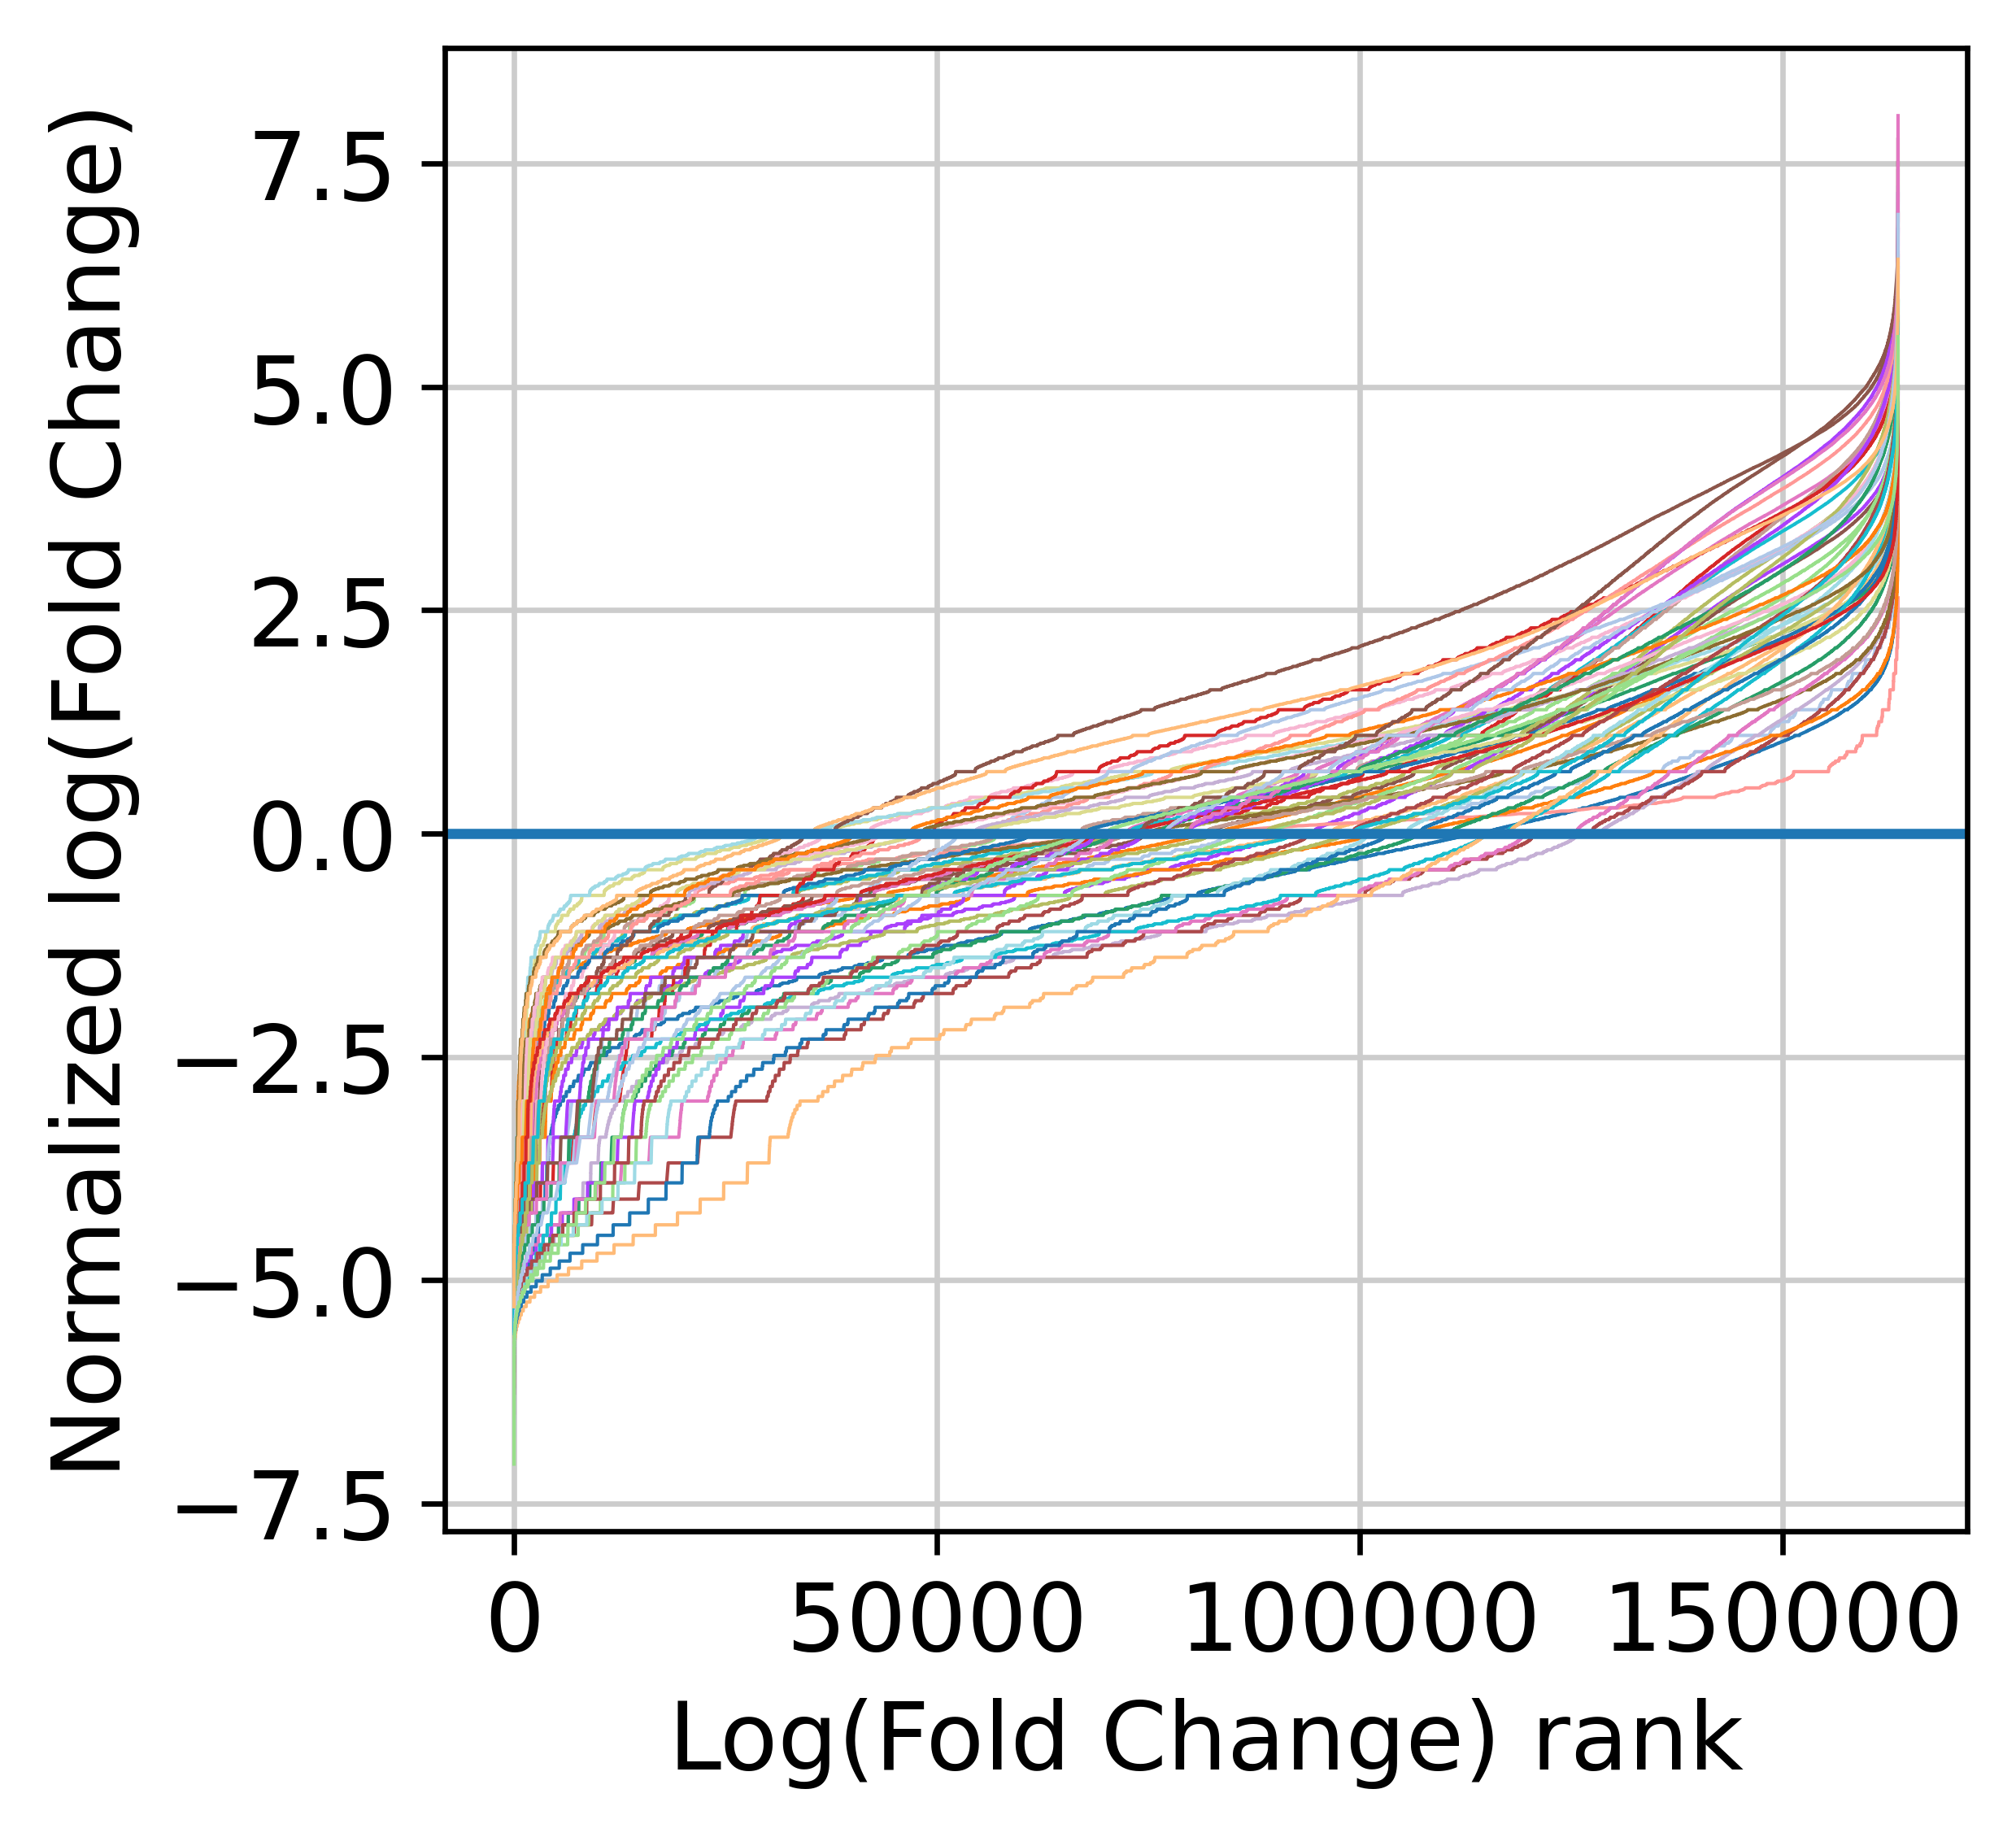

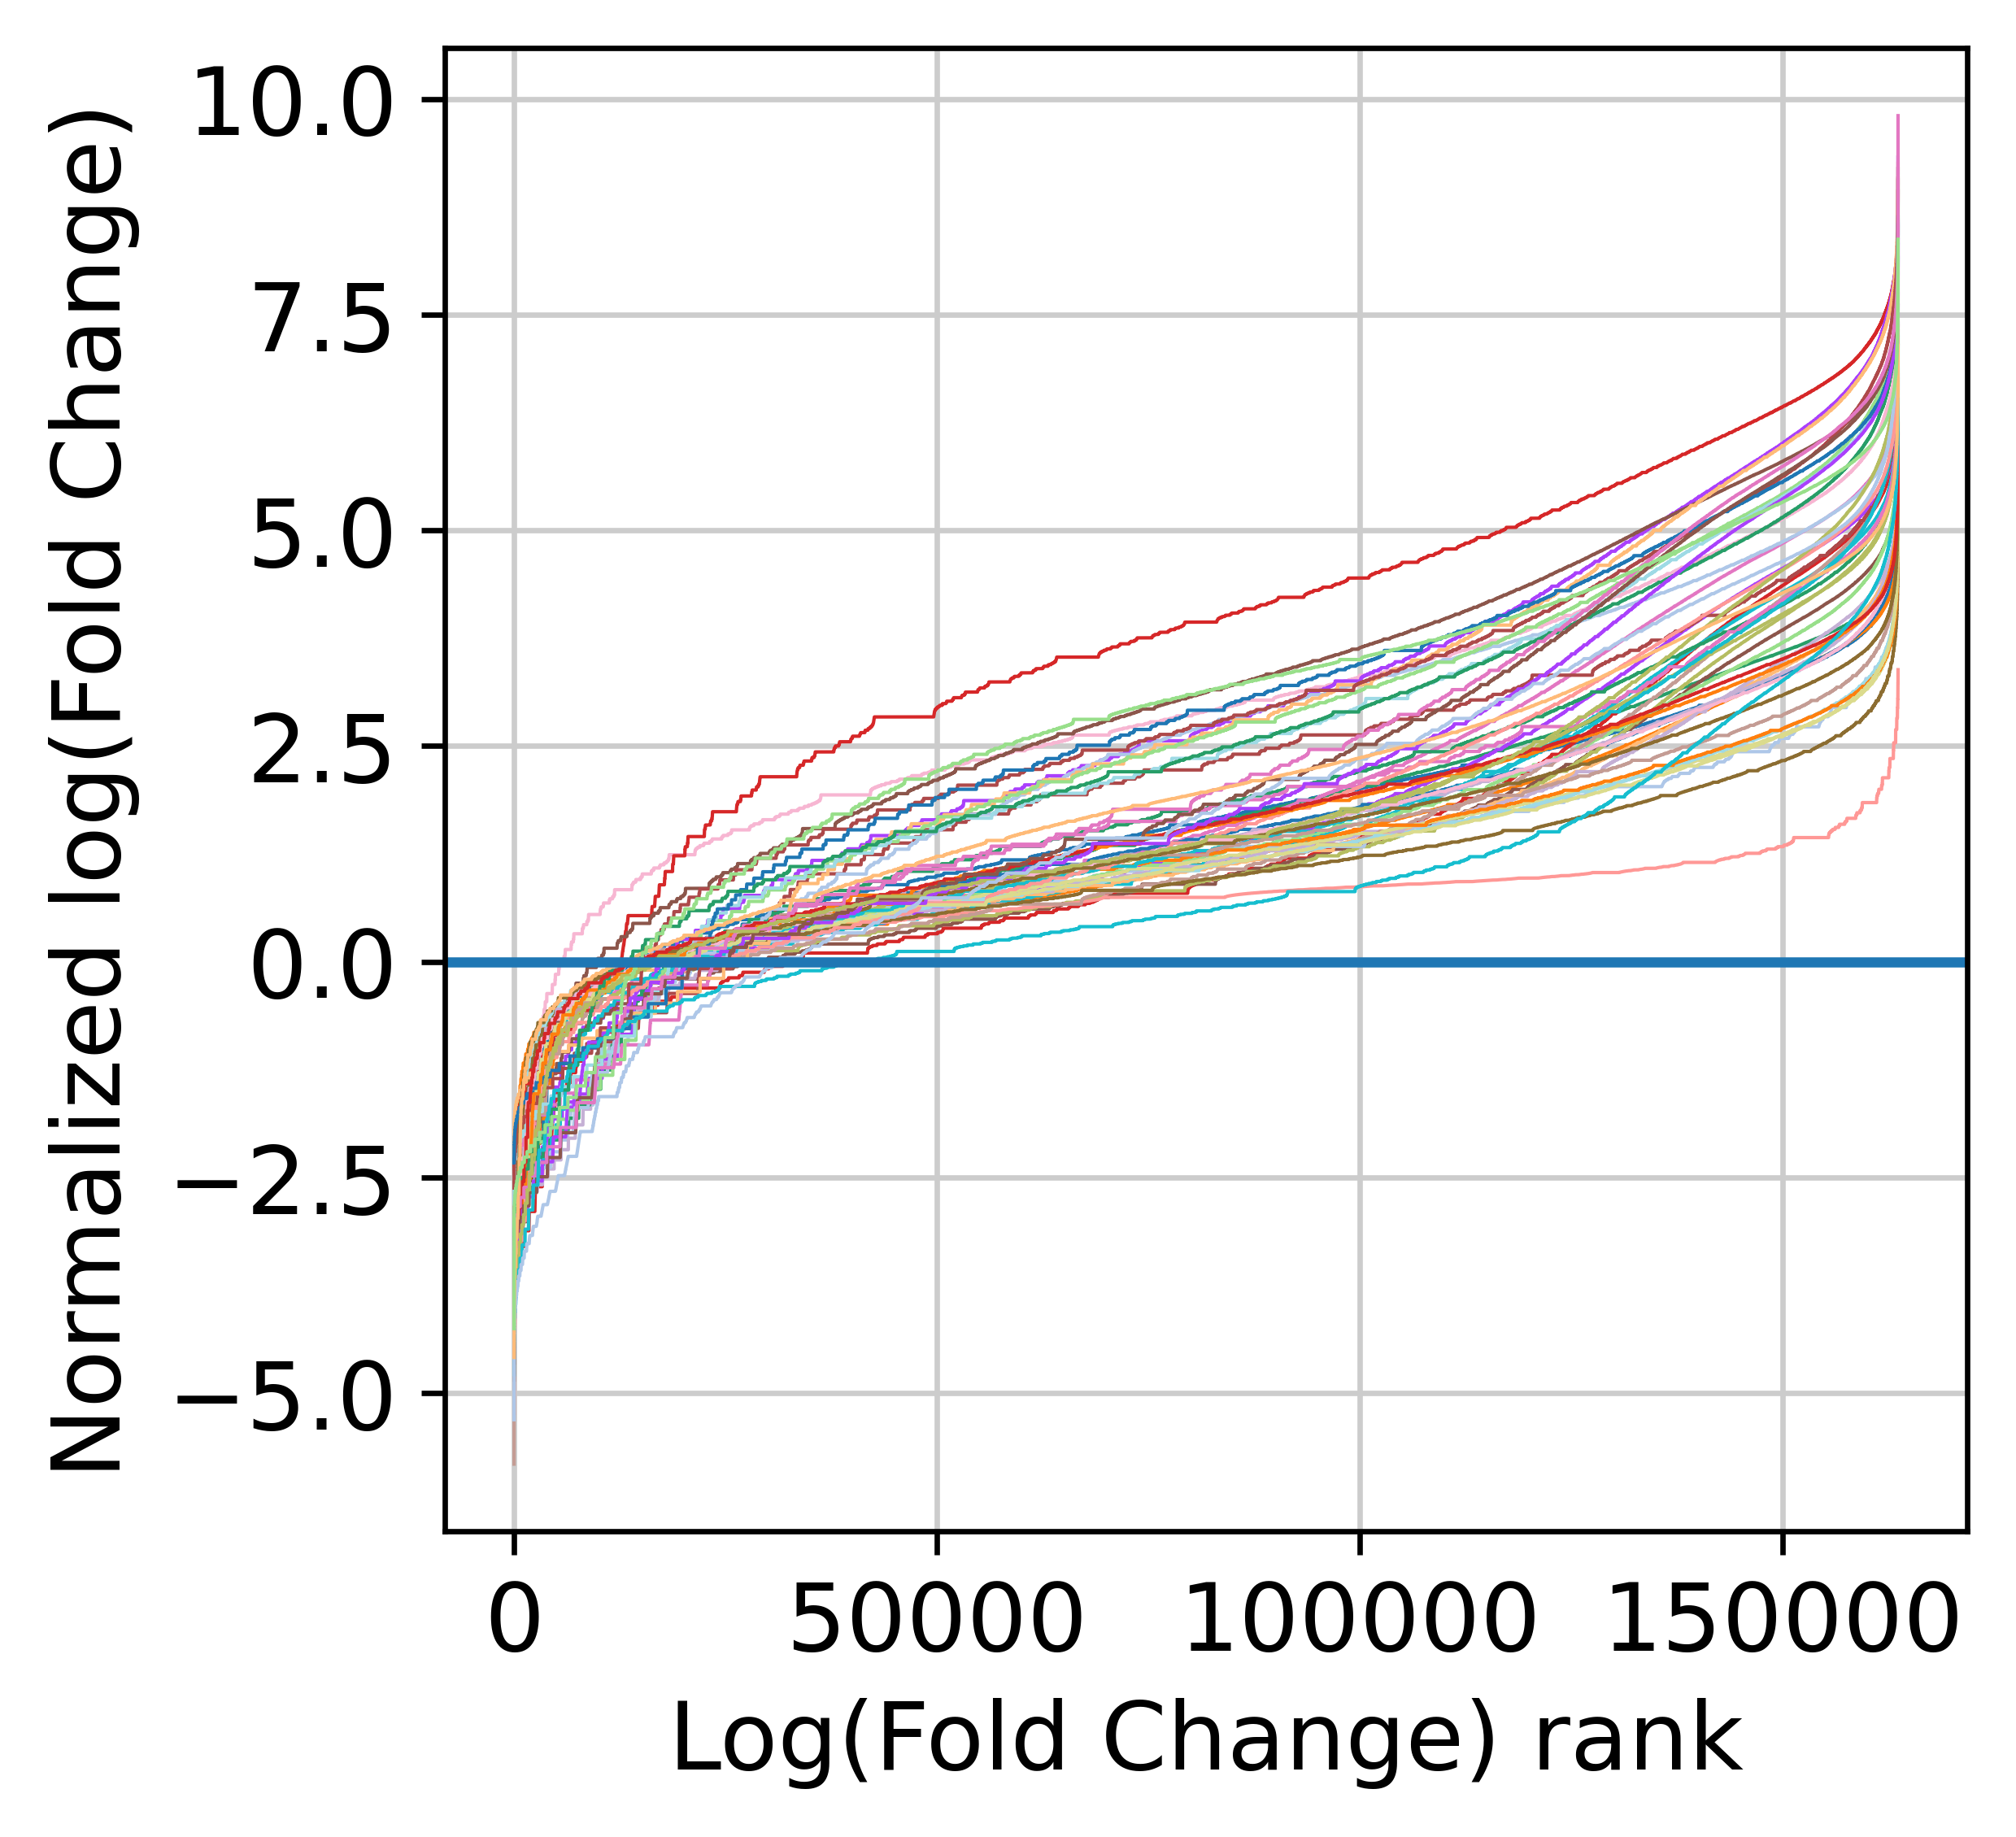

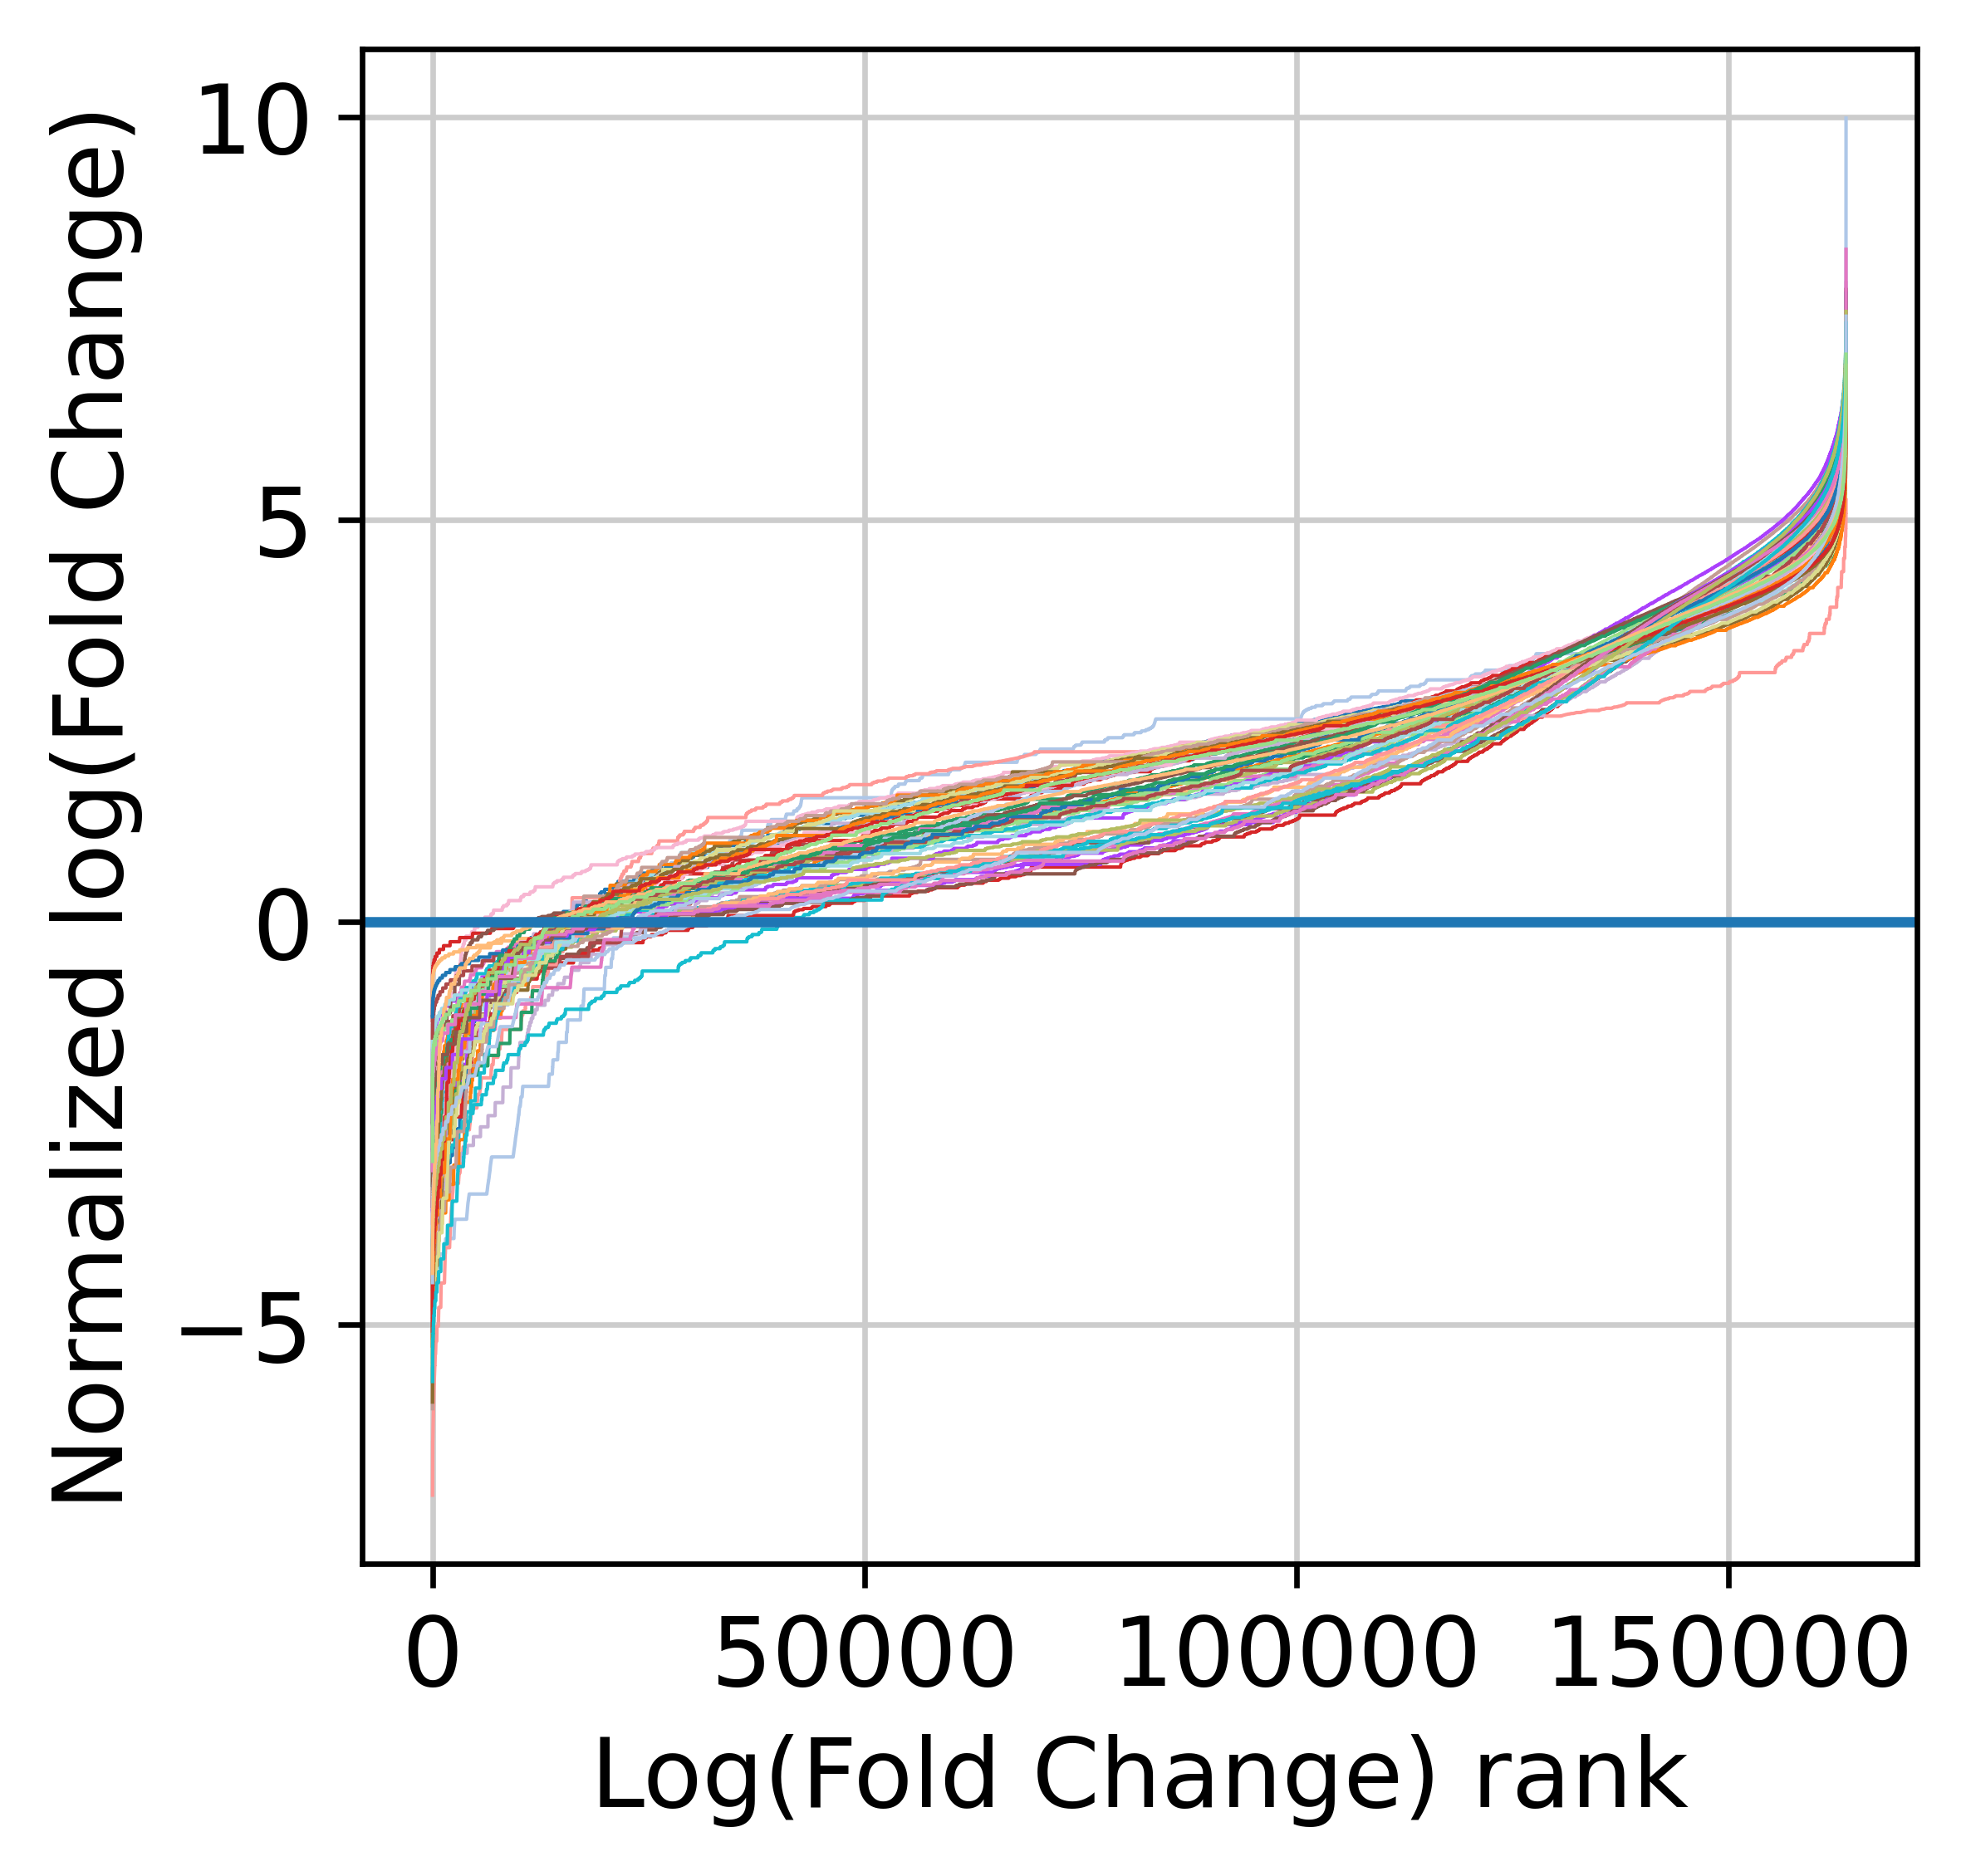

In [9]:
muffin.tools.rescale_input_center_scale(dataset, plot=True)
detectable = muffin.tools.trim_low_counts(dataset)
dataset = dataset[:, detectable]

The next step is to fit the mean-variance relationship and the compute residuals to the fitted Negative Binomial model.

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffinEnv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffinEnv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-b

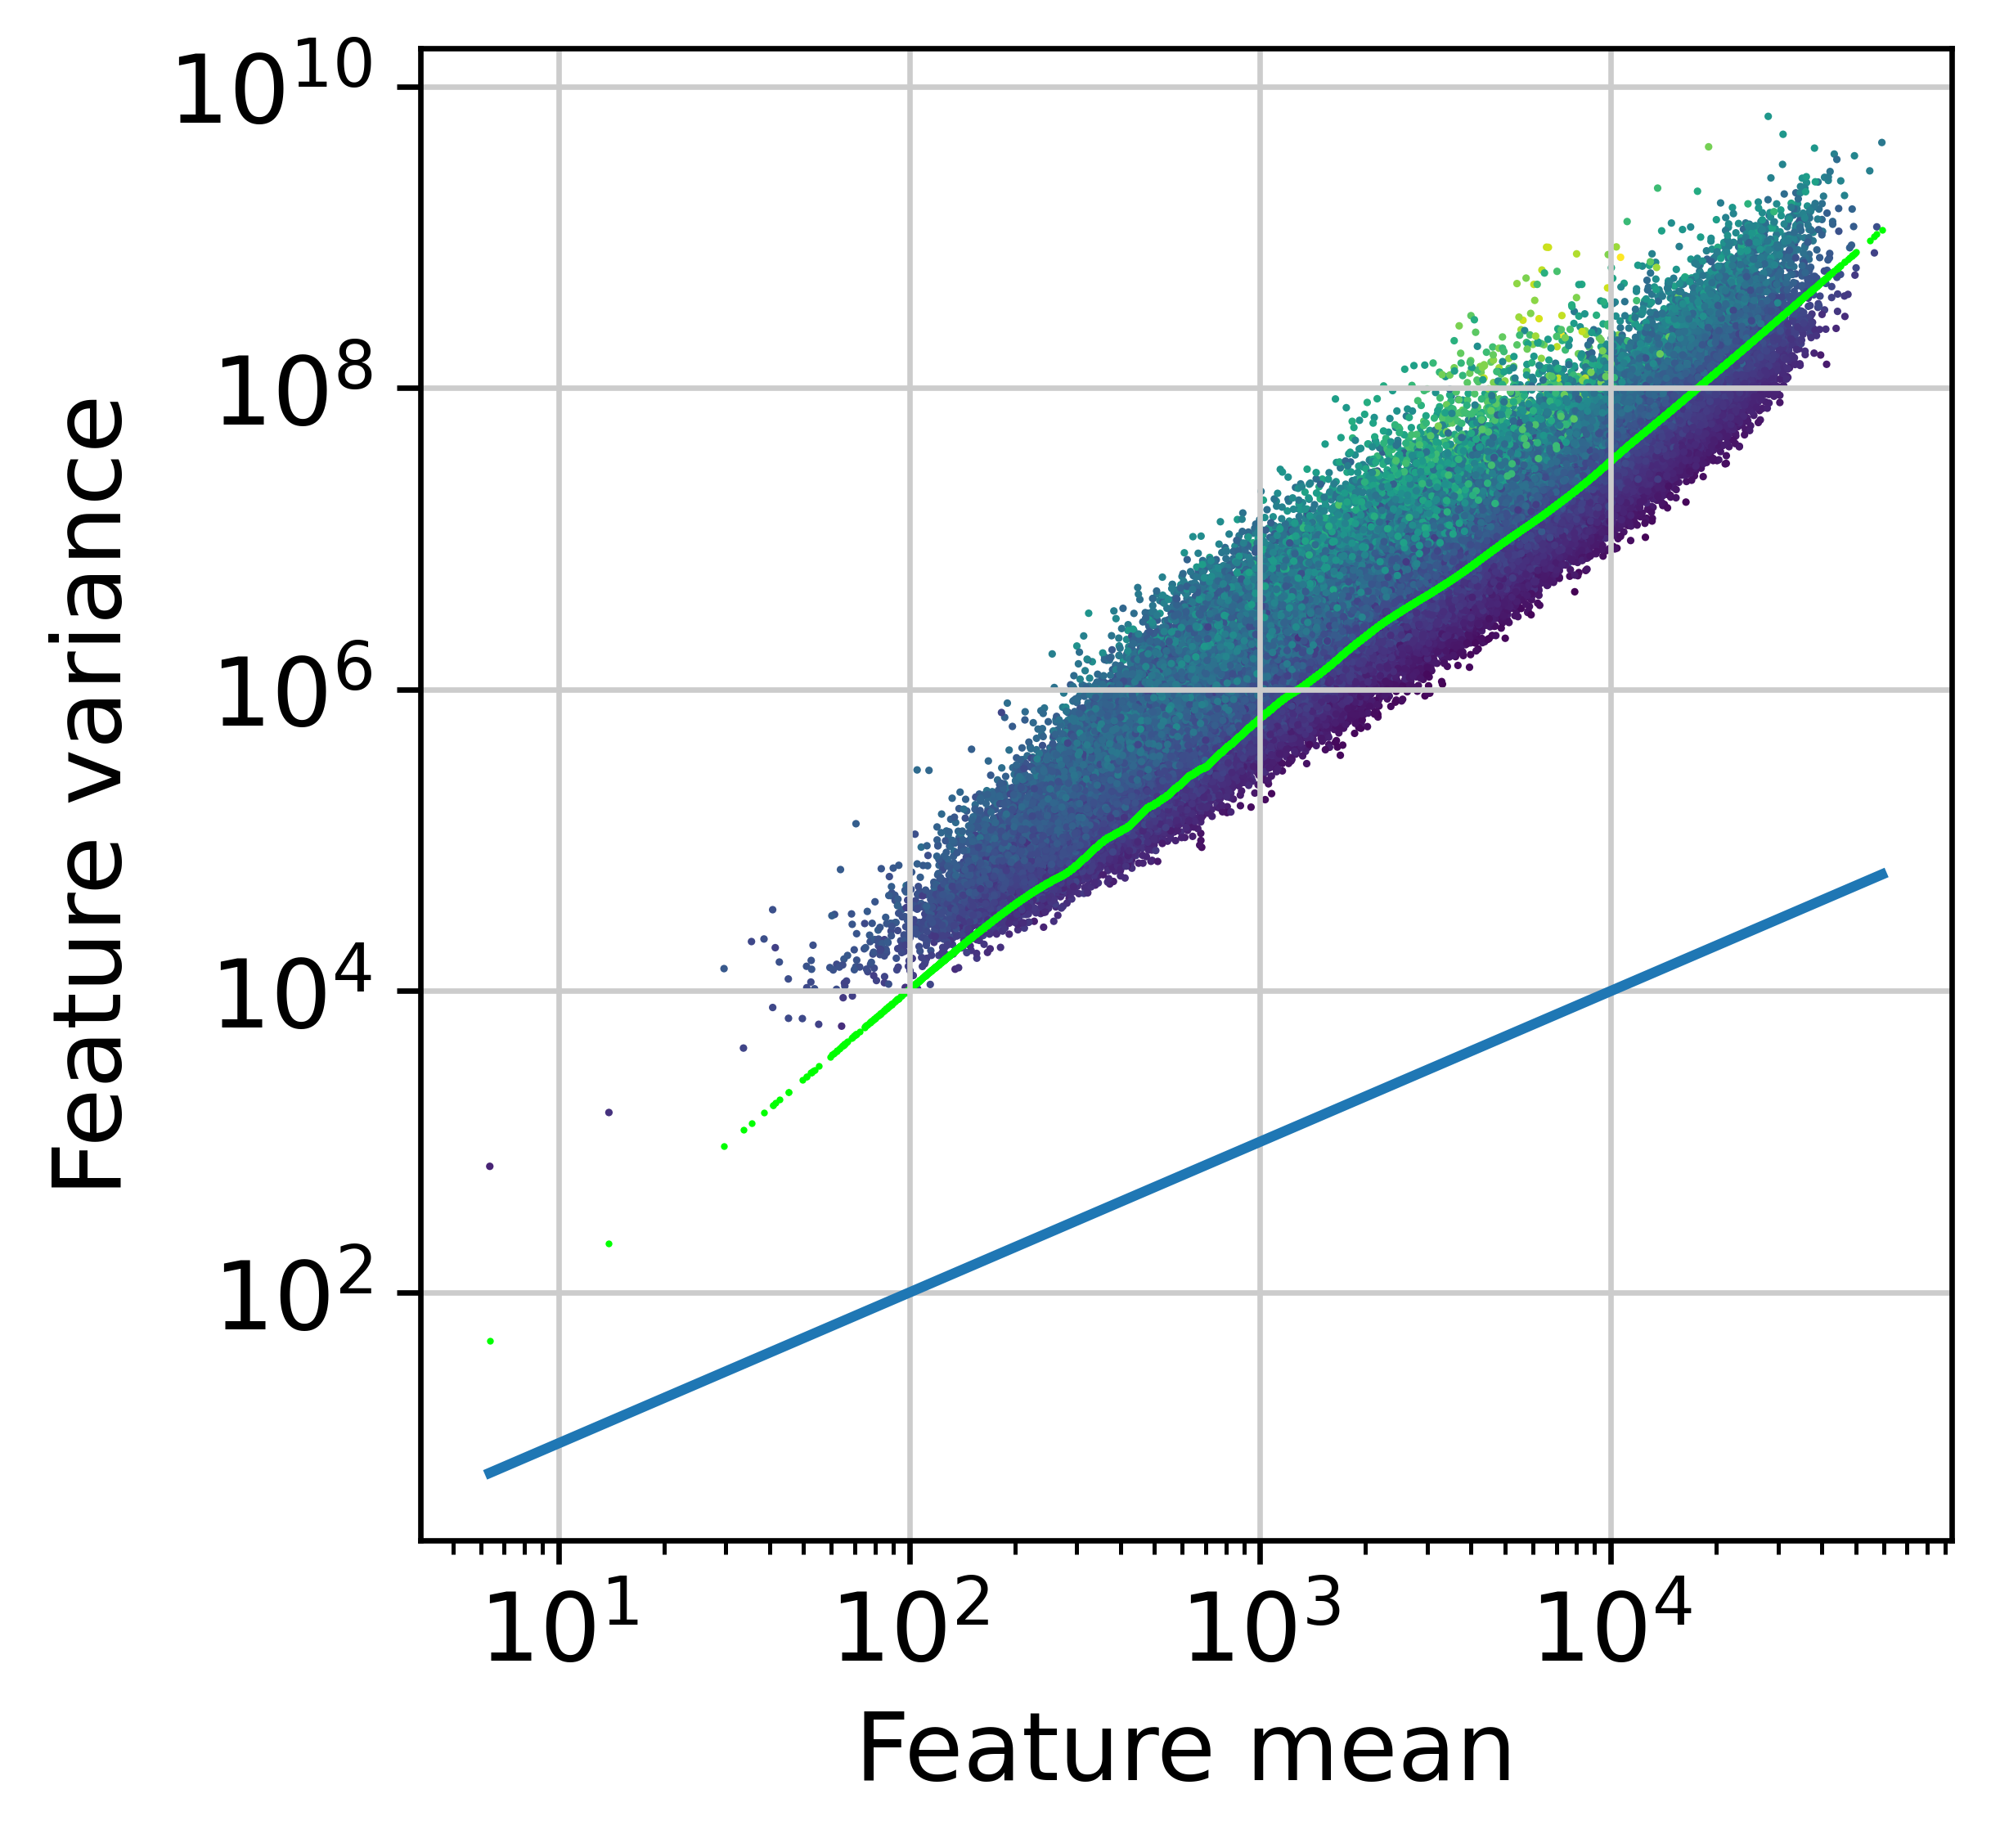

AnnData object with n_obs × n_vars = 52 × 163624
    obs: 'size_factors', 'size_factors_input', 'centered_lfc', 'pi0'
    var: 'Chromosome', 'Start', 'End', 'Strand', 'means', 'variances', 'reg_alpha'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random'
    obsm: 'design'
    layers: 'input', 'normalization_factors', 'residuals'

In [10]:
muffin.tools.compute_residuals(dataset, maxThreads=16)

We can perform feature selection to remove peaks with low information. Additionally for ChIP-seq we propose a tool to remove features with insufficient enrichment over input, which can be useful if you use a large catalogue of regions without peak calling. As peak calling was already performed, almost all features are passing this step.

<Figure size 1200x1200 with 0 Axes>

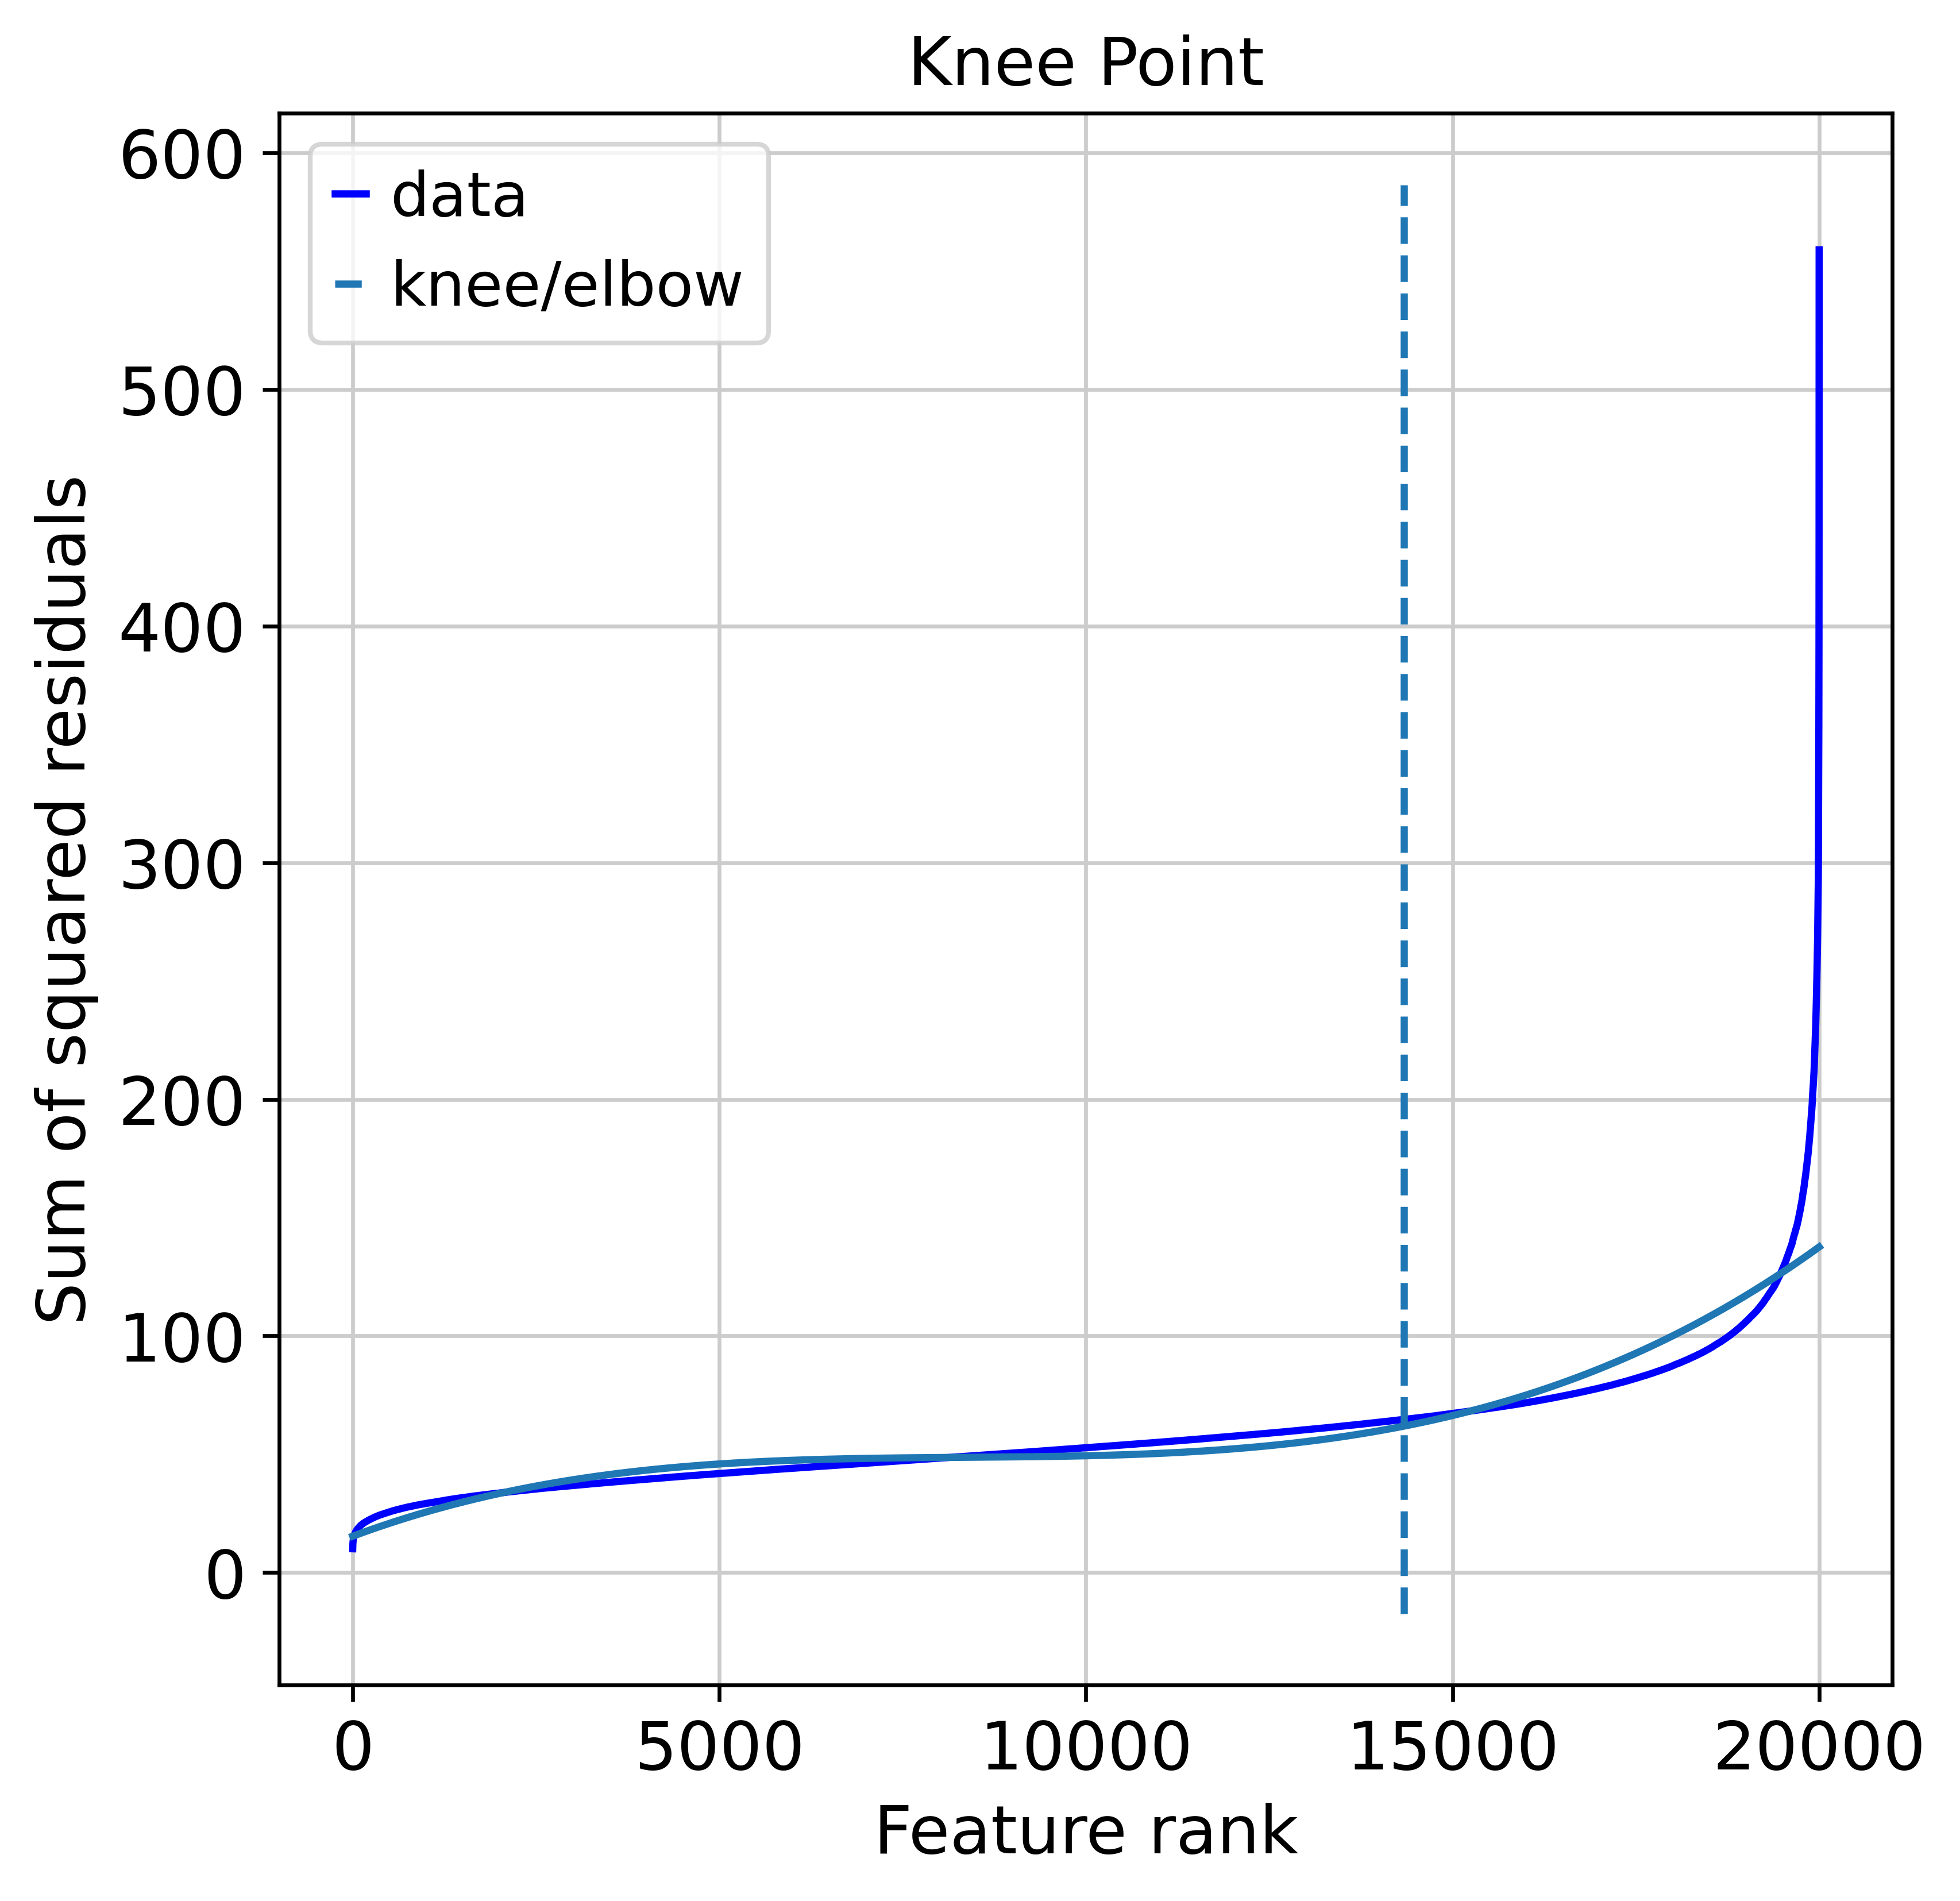

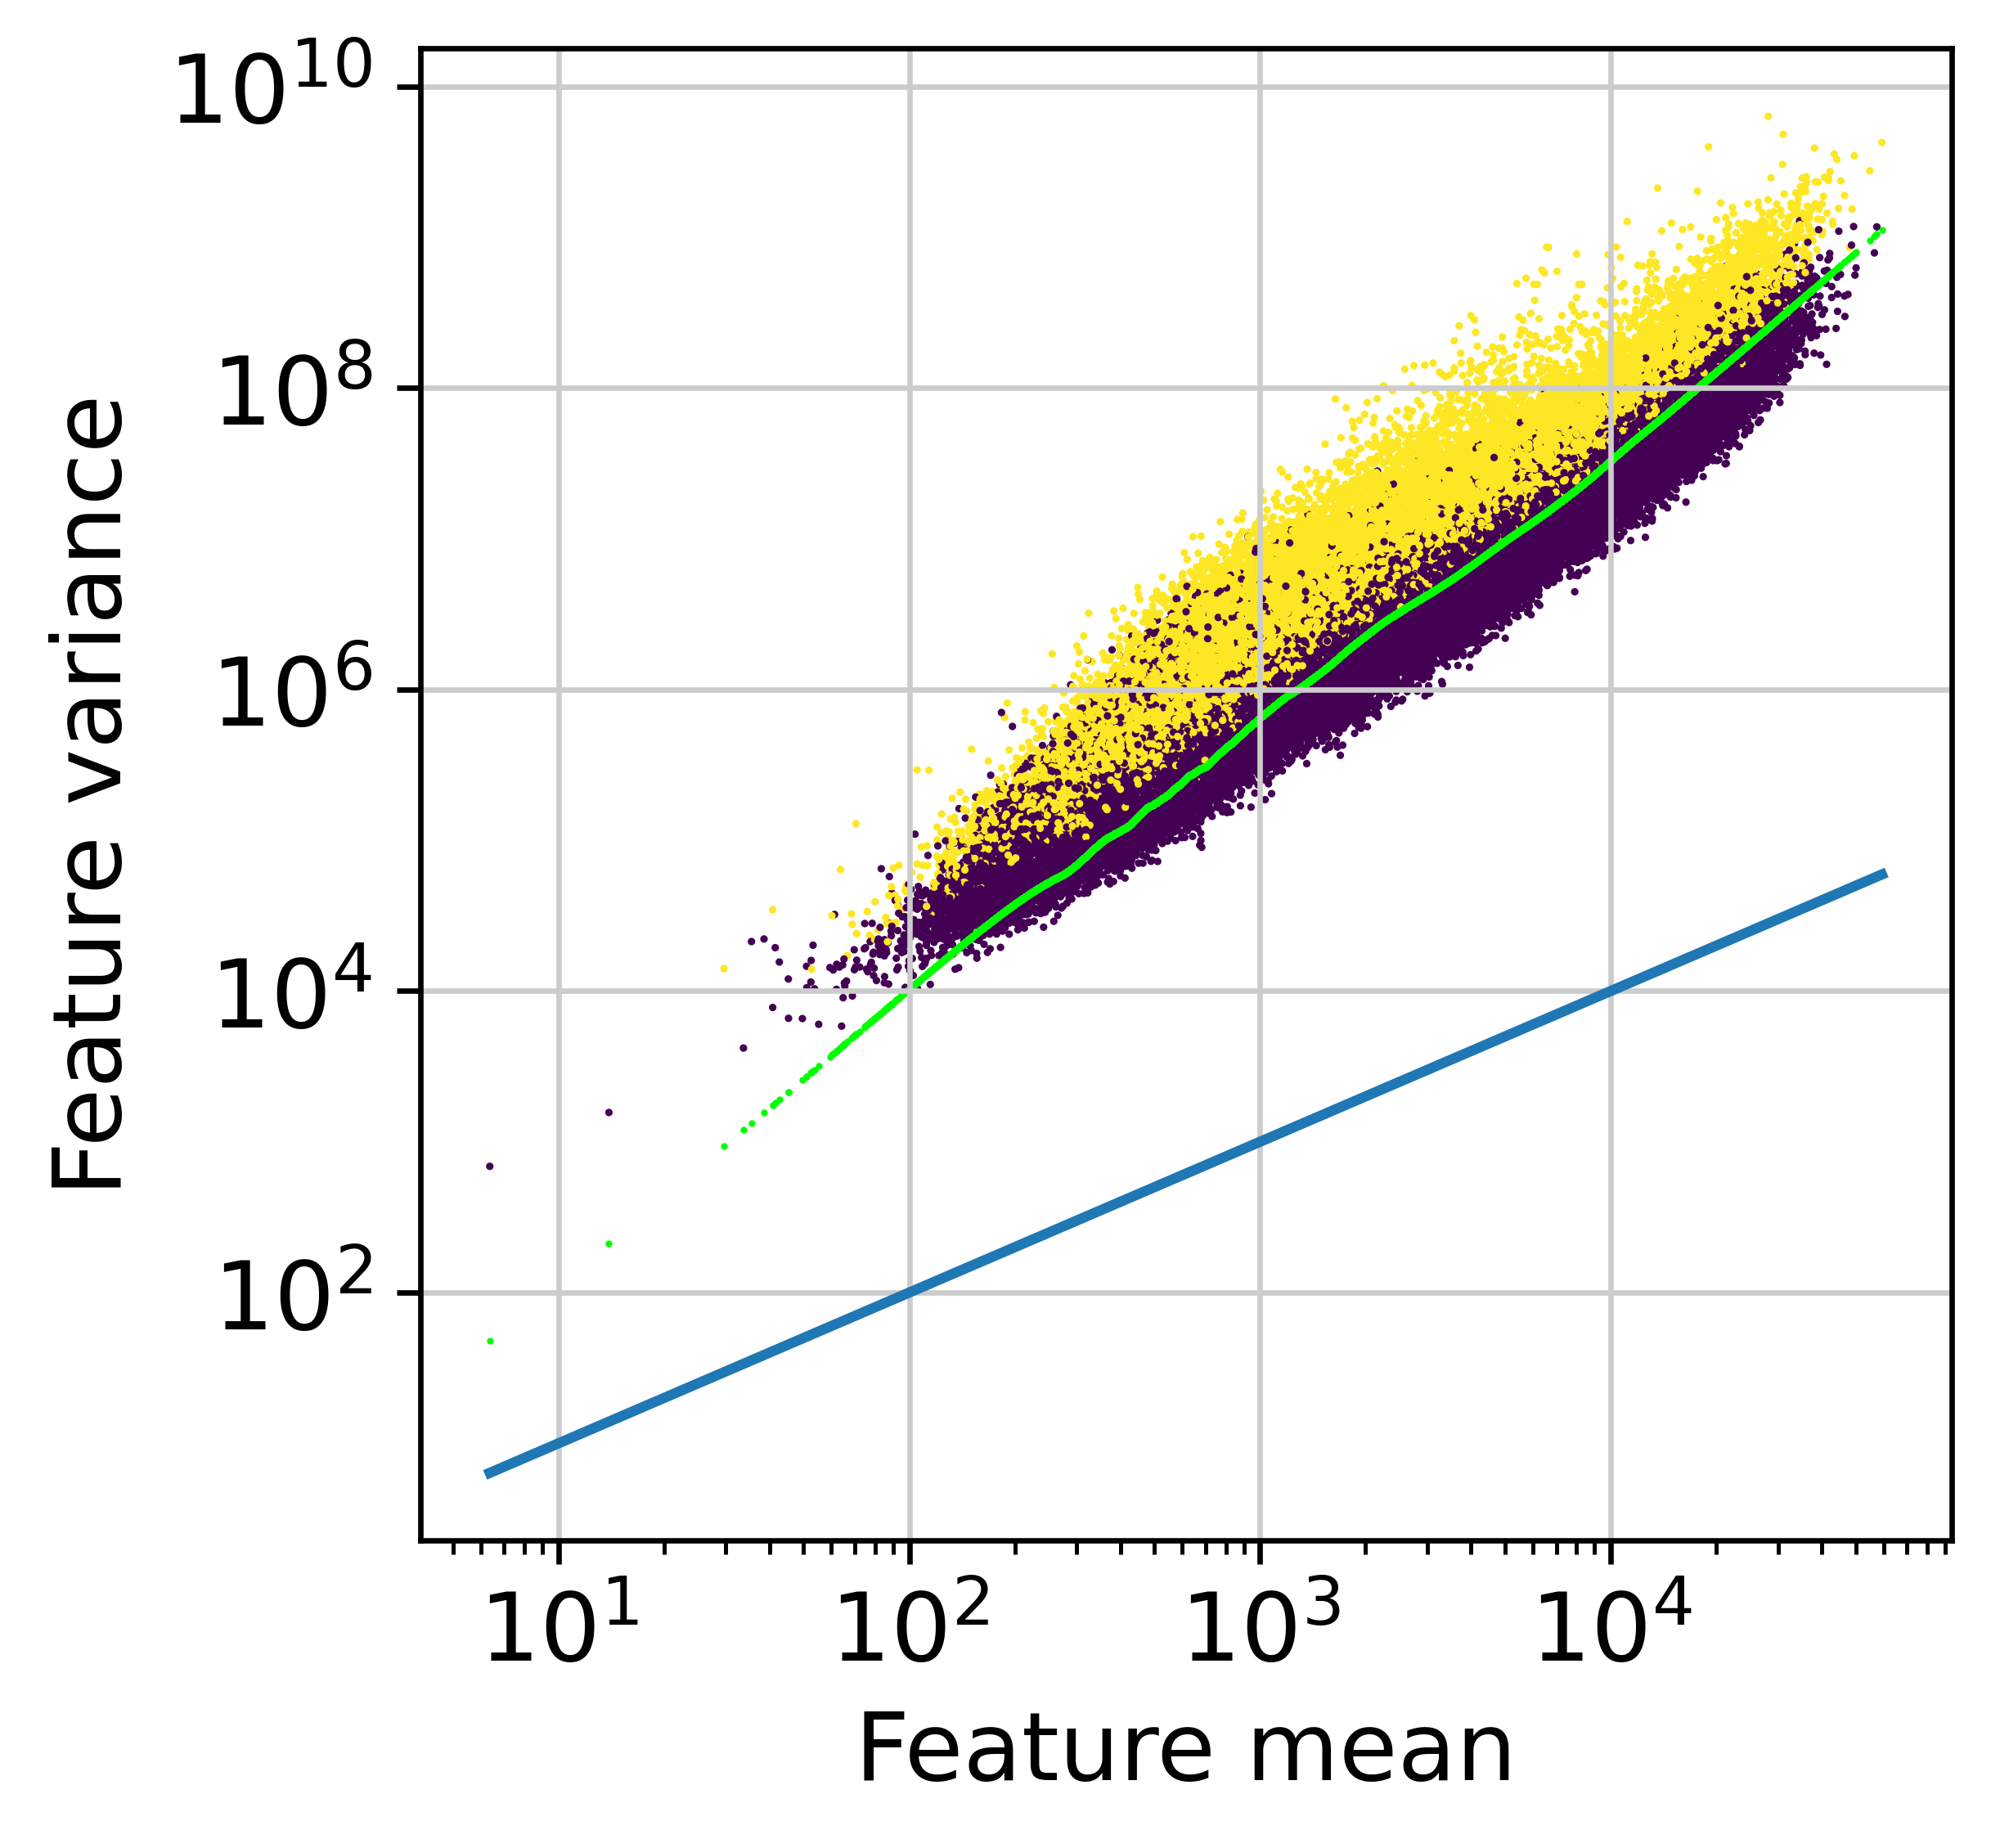

0.9992360533907007


In [11]:
peaks = muffin.tools.pseudo_peak_calling(dataset)
hv = muffin.tools.feature_selection_elbow(dataset)
print(np.mean(peaks))

Next, we perform dimensionnality reduction through with PCA and UMAP.

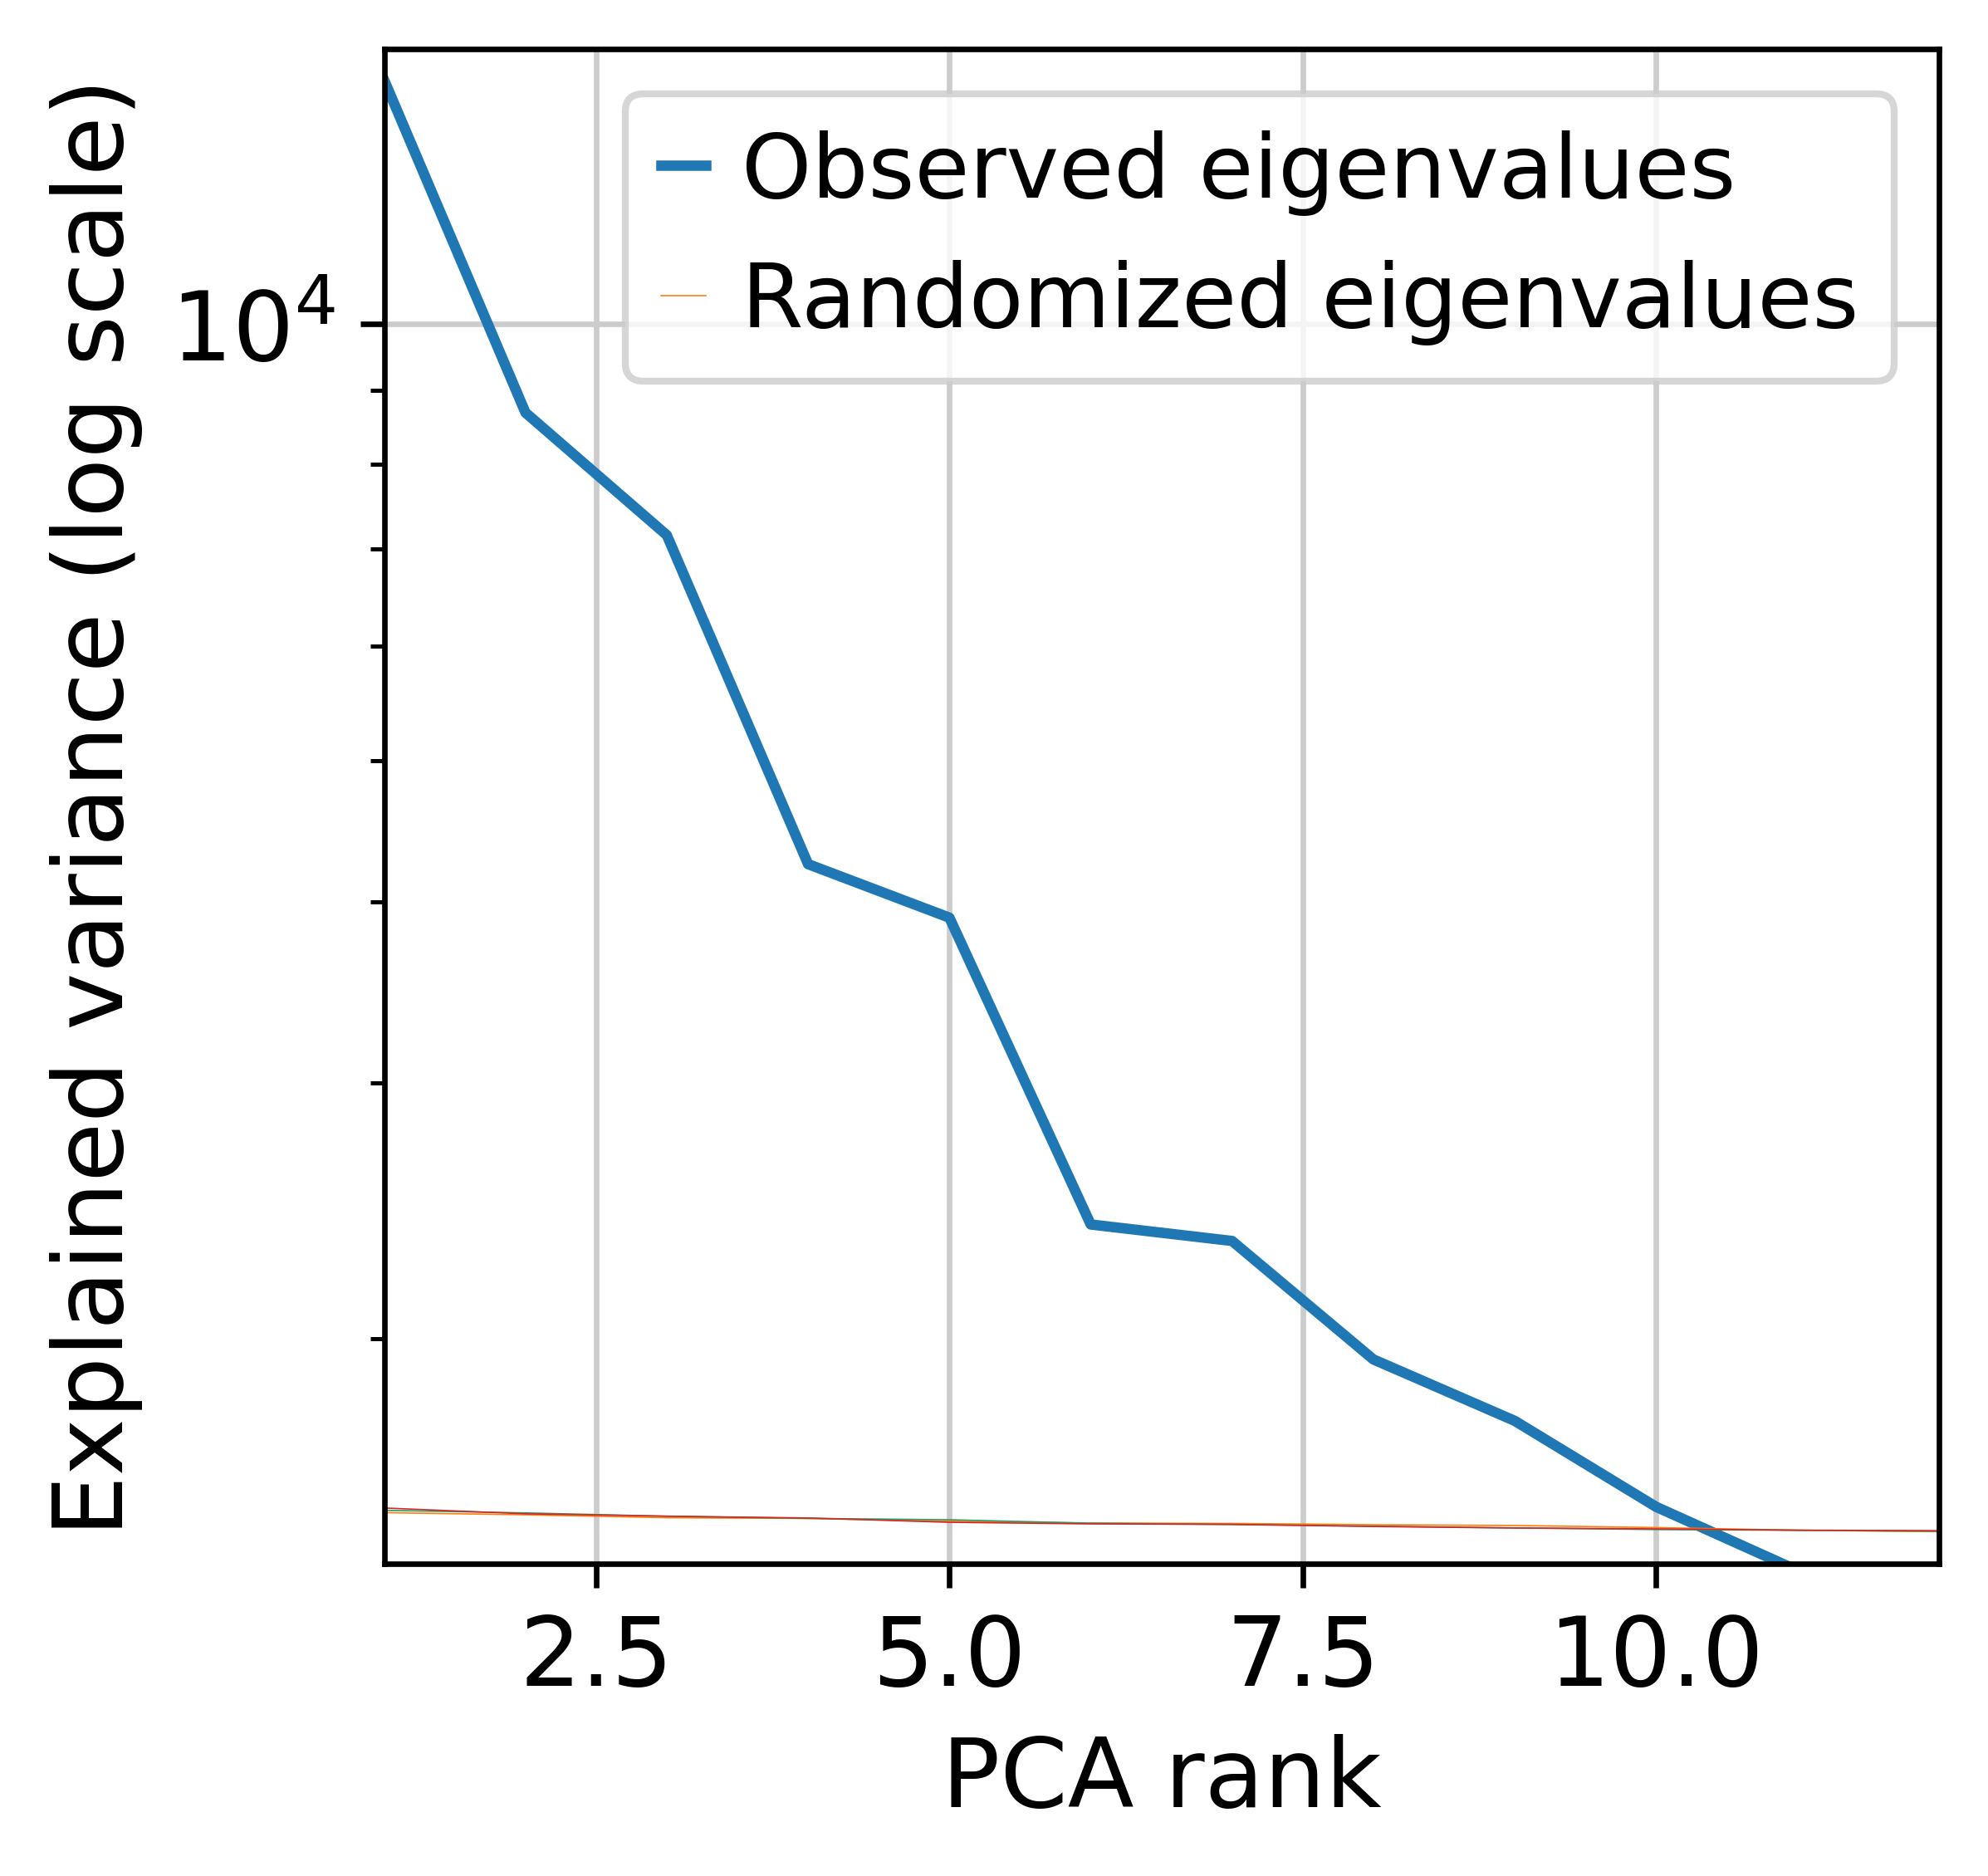

AnnData object with n_obs × n_vars = 52 × 163624
    obs: 'size_factors', 'size_factors_input', 'centered_lfc', 'pi0'
    var: 'Chromosome', 'Start', 'End', 'Strand', 'means', 'variances', 'reg_alpha'
    uns: 'counts_random', 'tot_mapped_counts', 'input_random', 'pca'
    obsm: 'design', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'input', 'normalization_factors', 'residuals'

In [12]:
muffin.tools.compute_pa_pca(dataset, feature_mask=peaks&hv, plot=True)
muffin.tools.compute_umap(dataset)

Display the results. Note that we can use scanpy functions here!

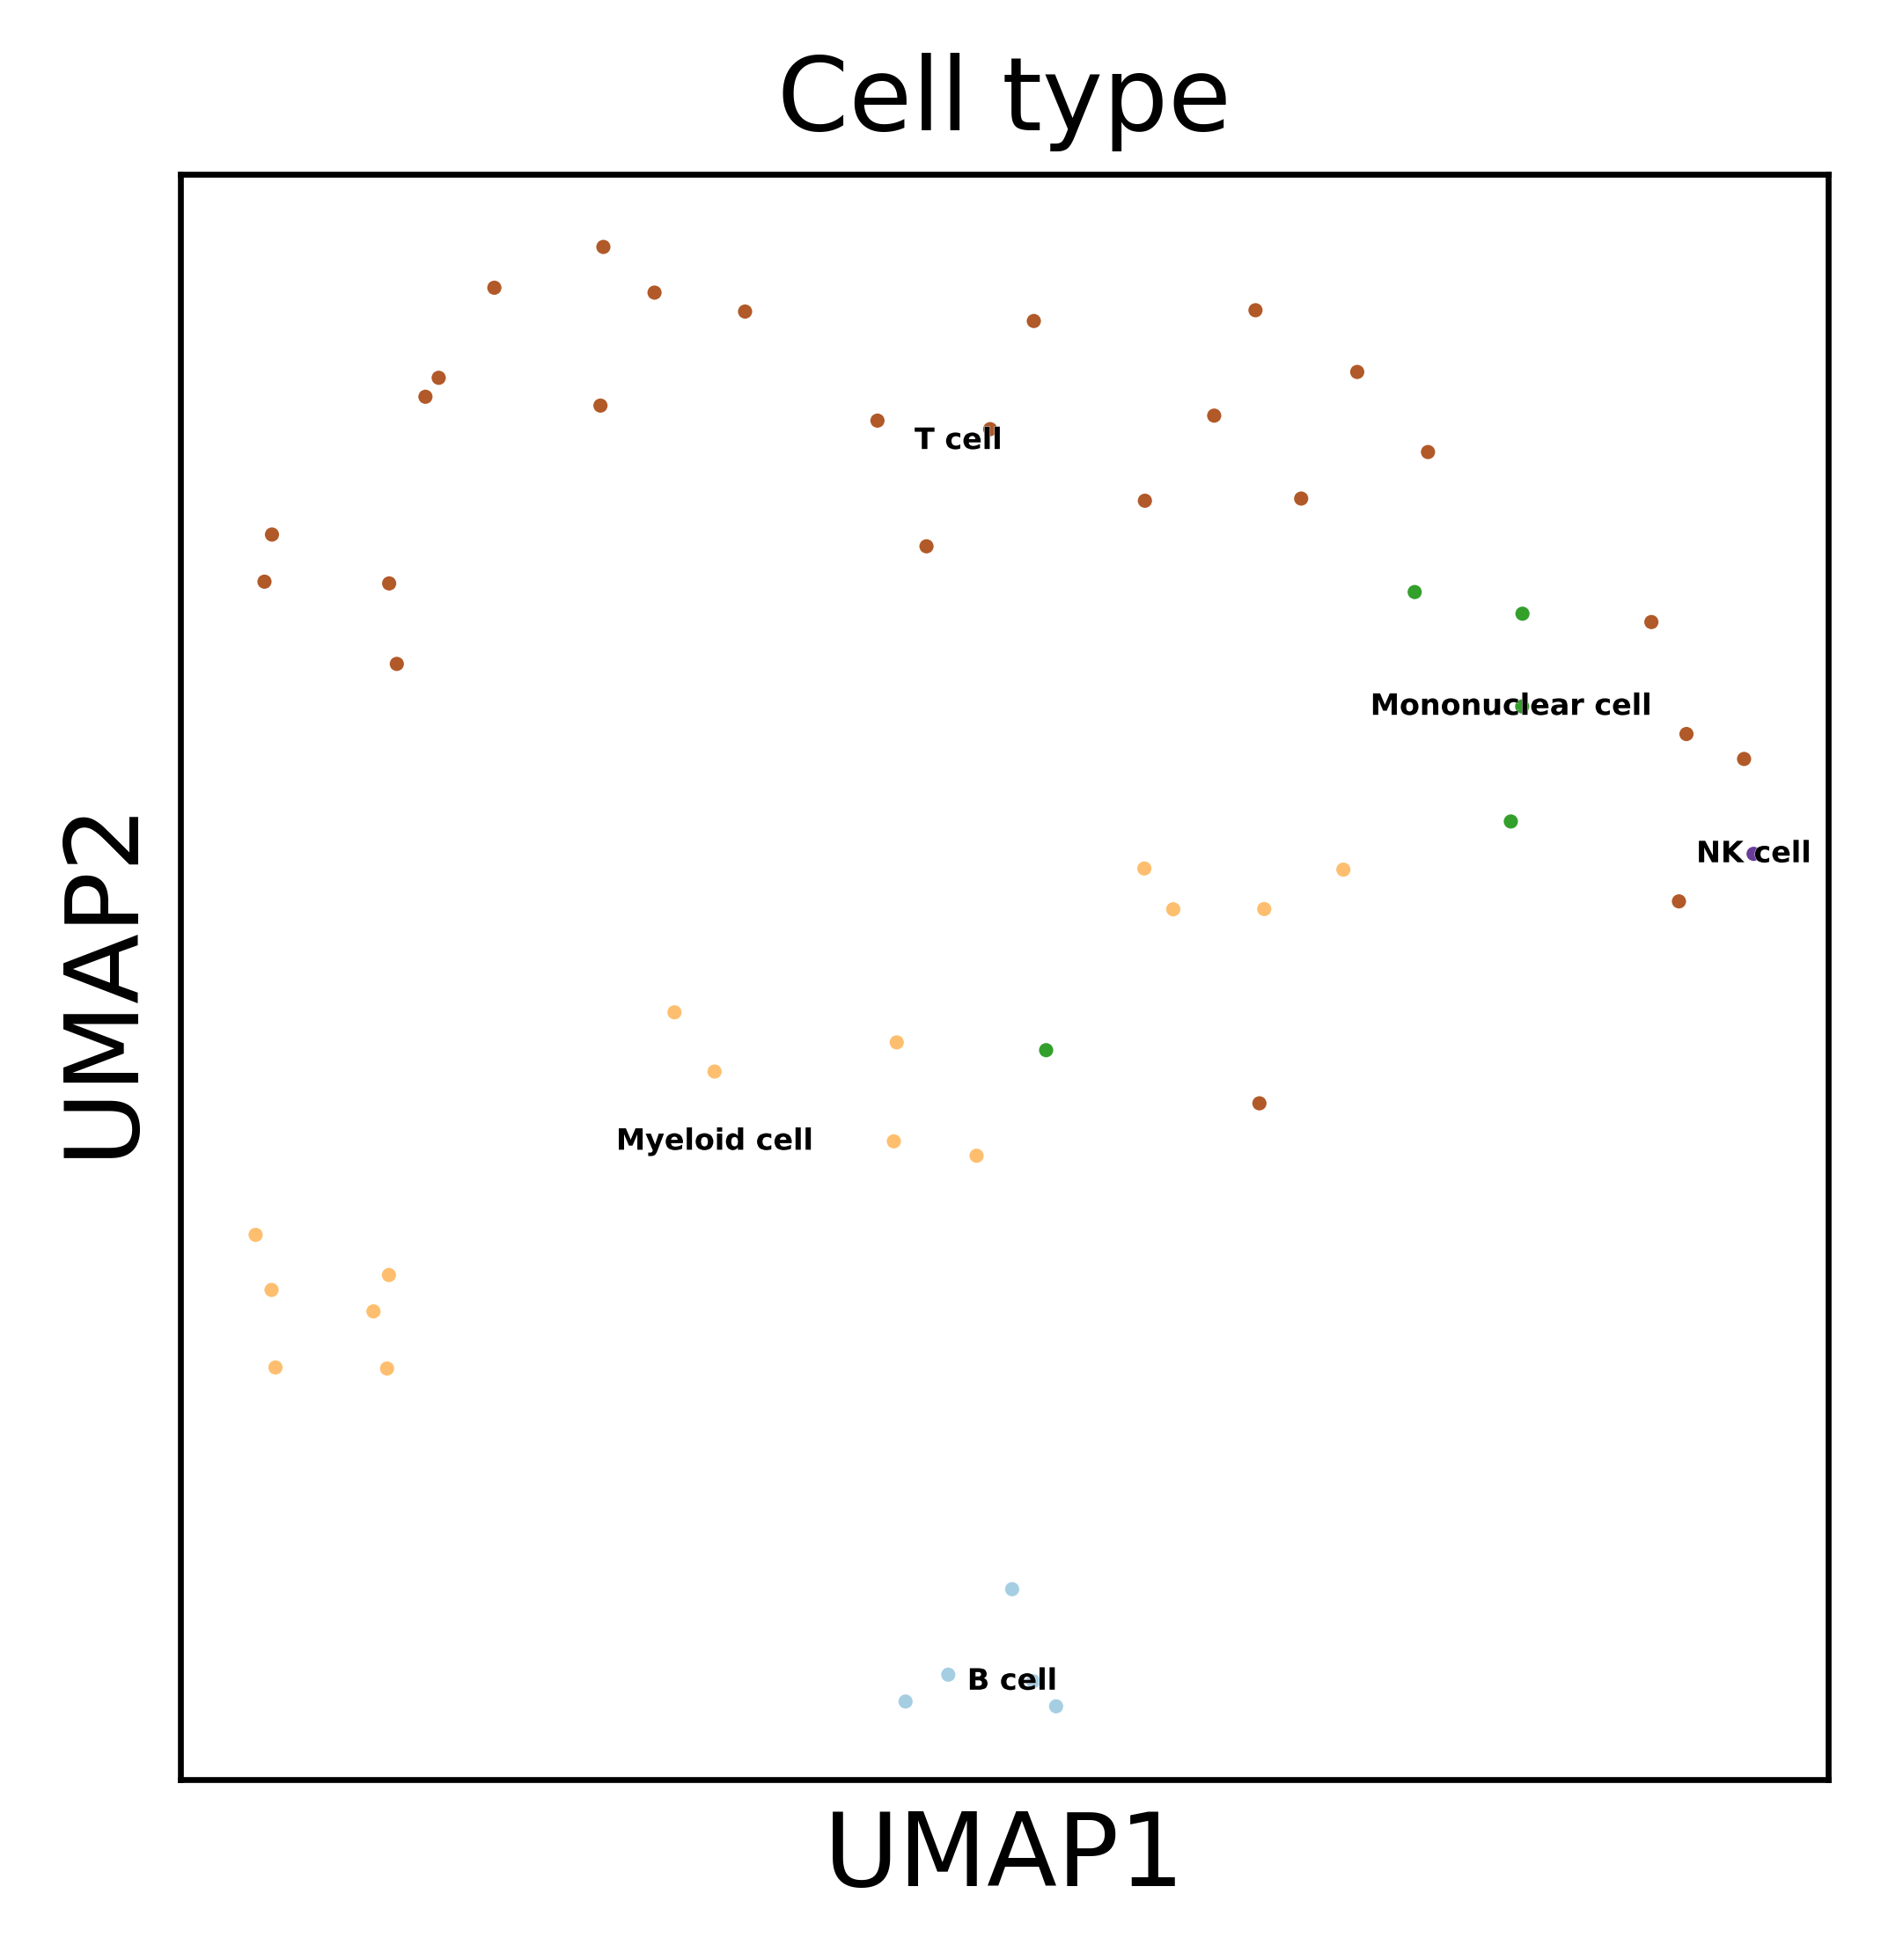

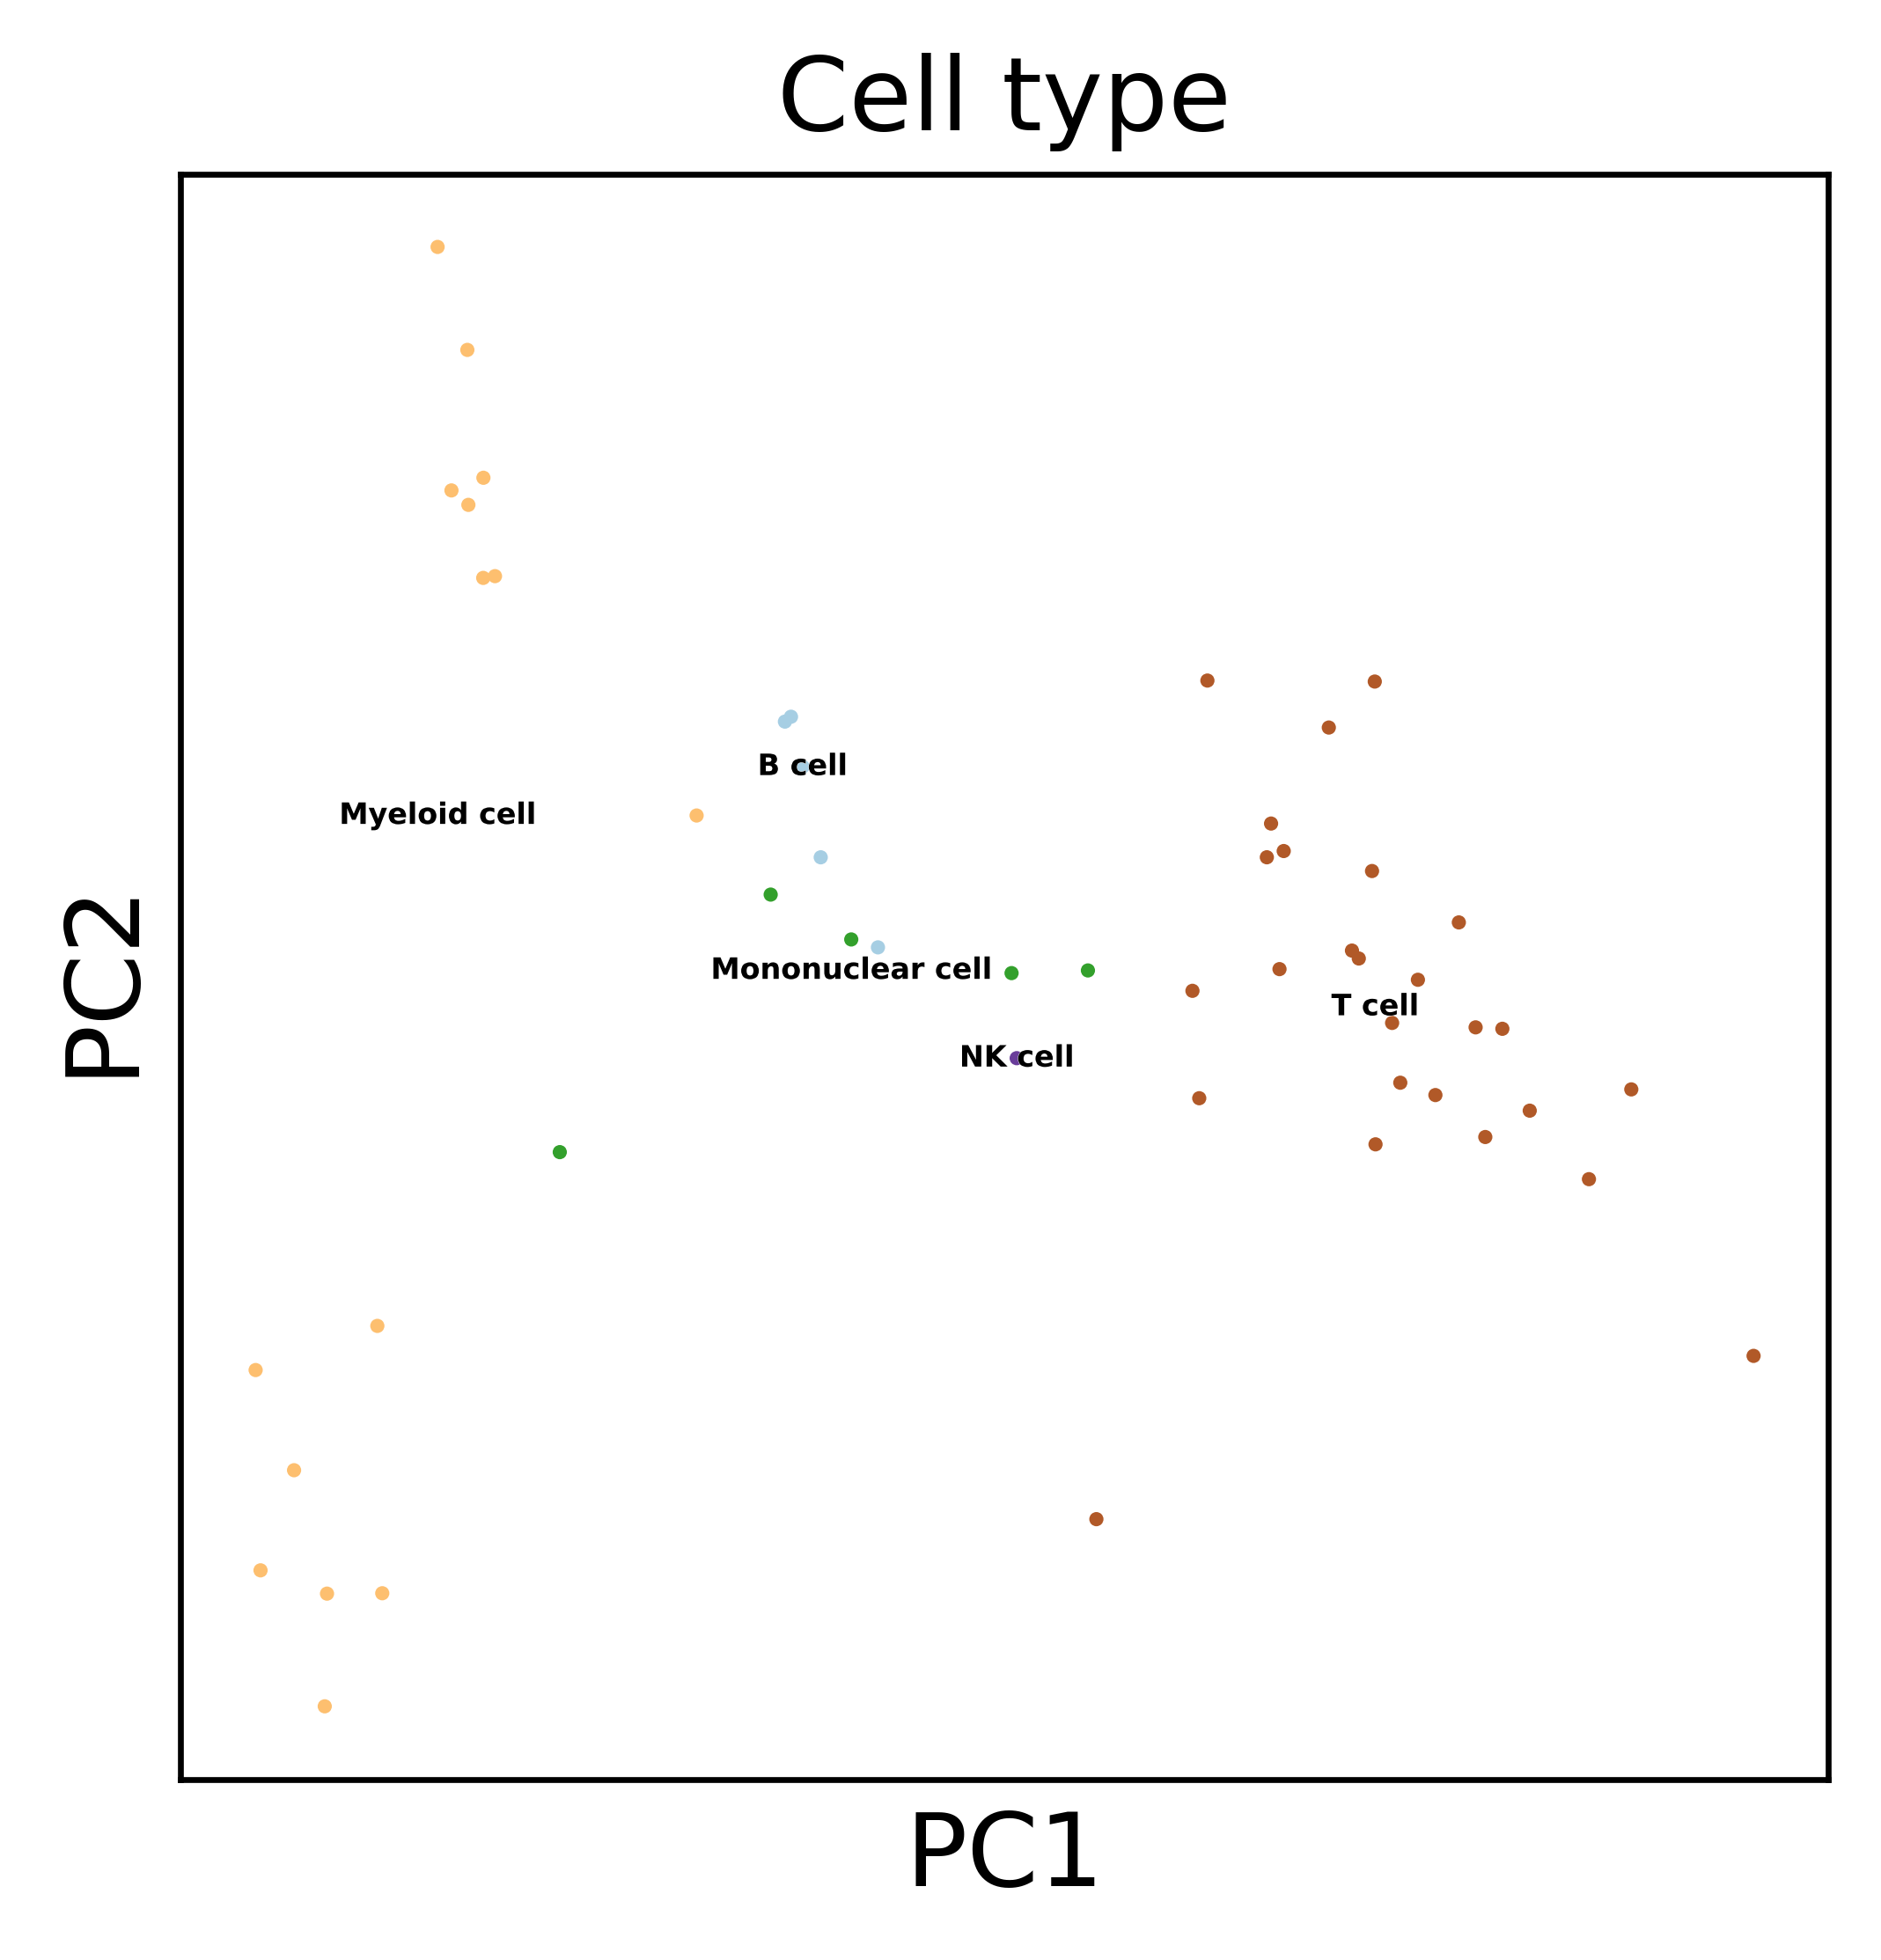

In [13]:
# Append cell type info to the dataset
dataset.obs["Cell type detailed"] = metadata_chip["Biosample term name"].values
dataset.obs["Cell type"] = metadata_chip["Biosample cell type"].values
sc.pl.umap(dataset, color='Cell type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='Paired')
sc.pl.pca(dataset, color='Cell type', legend_loc='on data',
                legend_fontsize=4, legend_fontoutline=0.1, s=15.0,
                palette='Paired')

We can also use heatmaps, even if we have a large number of features :

46293


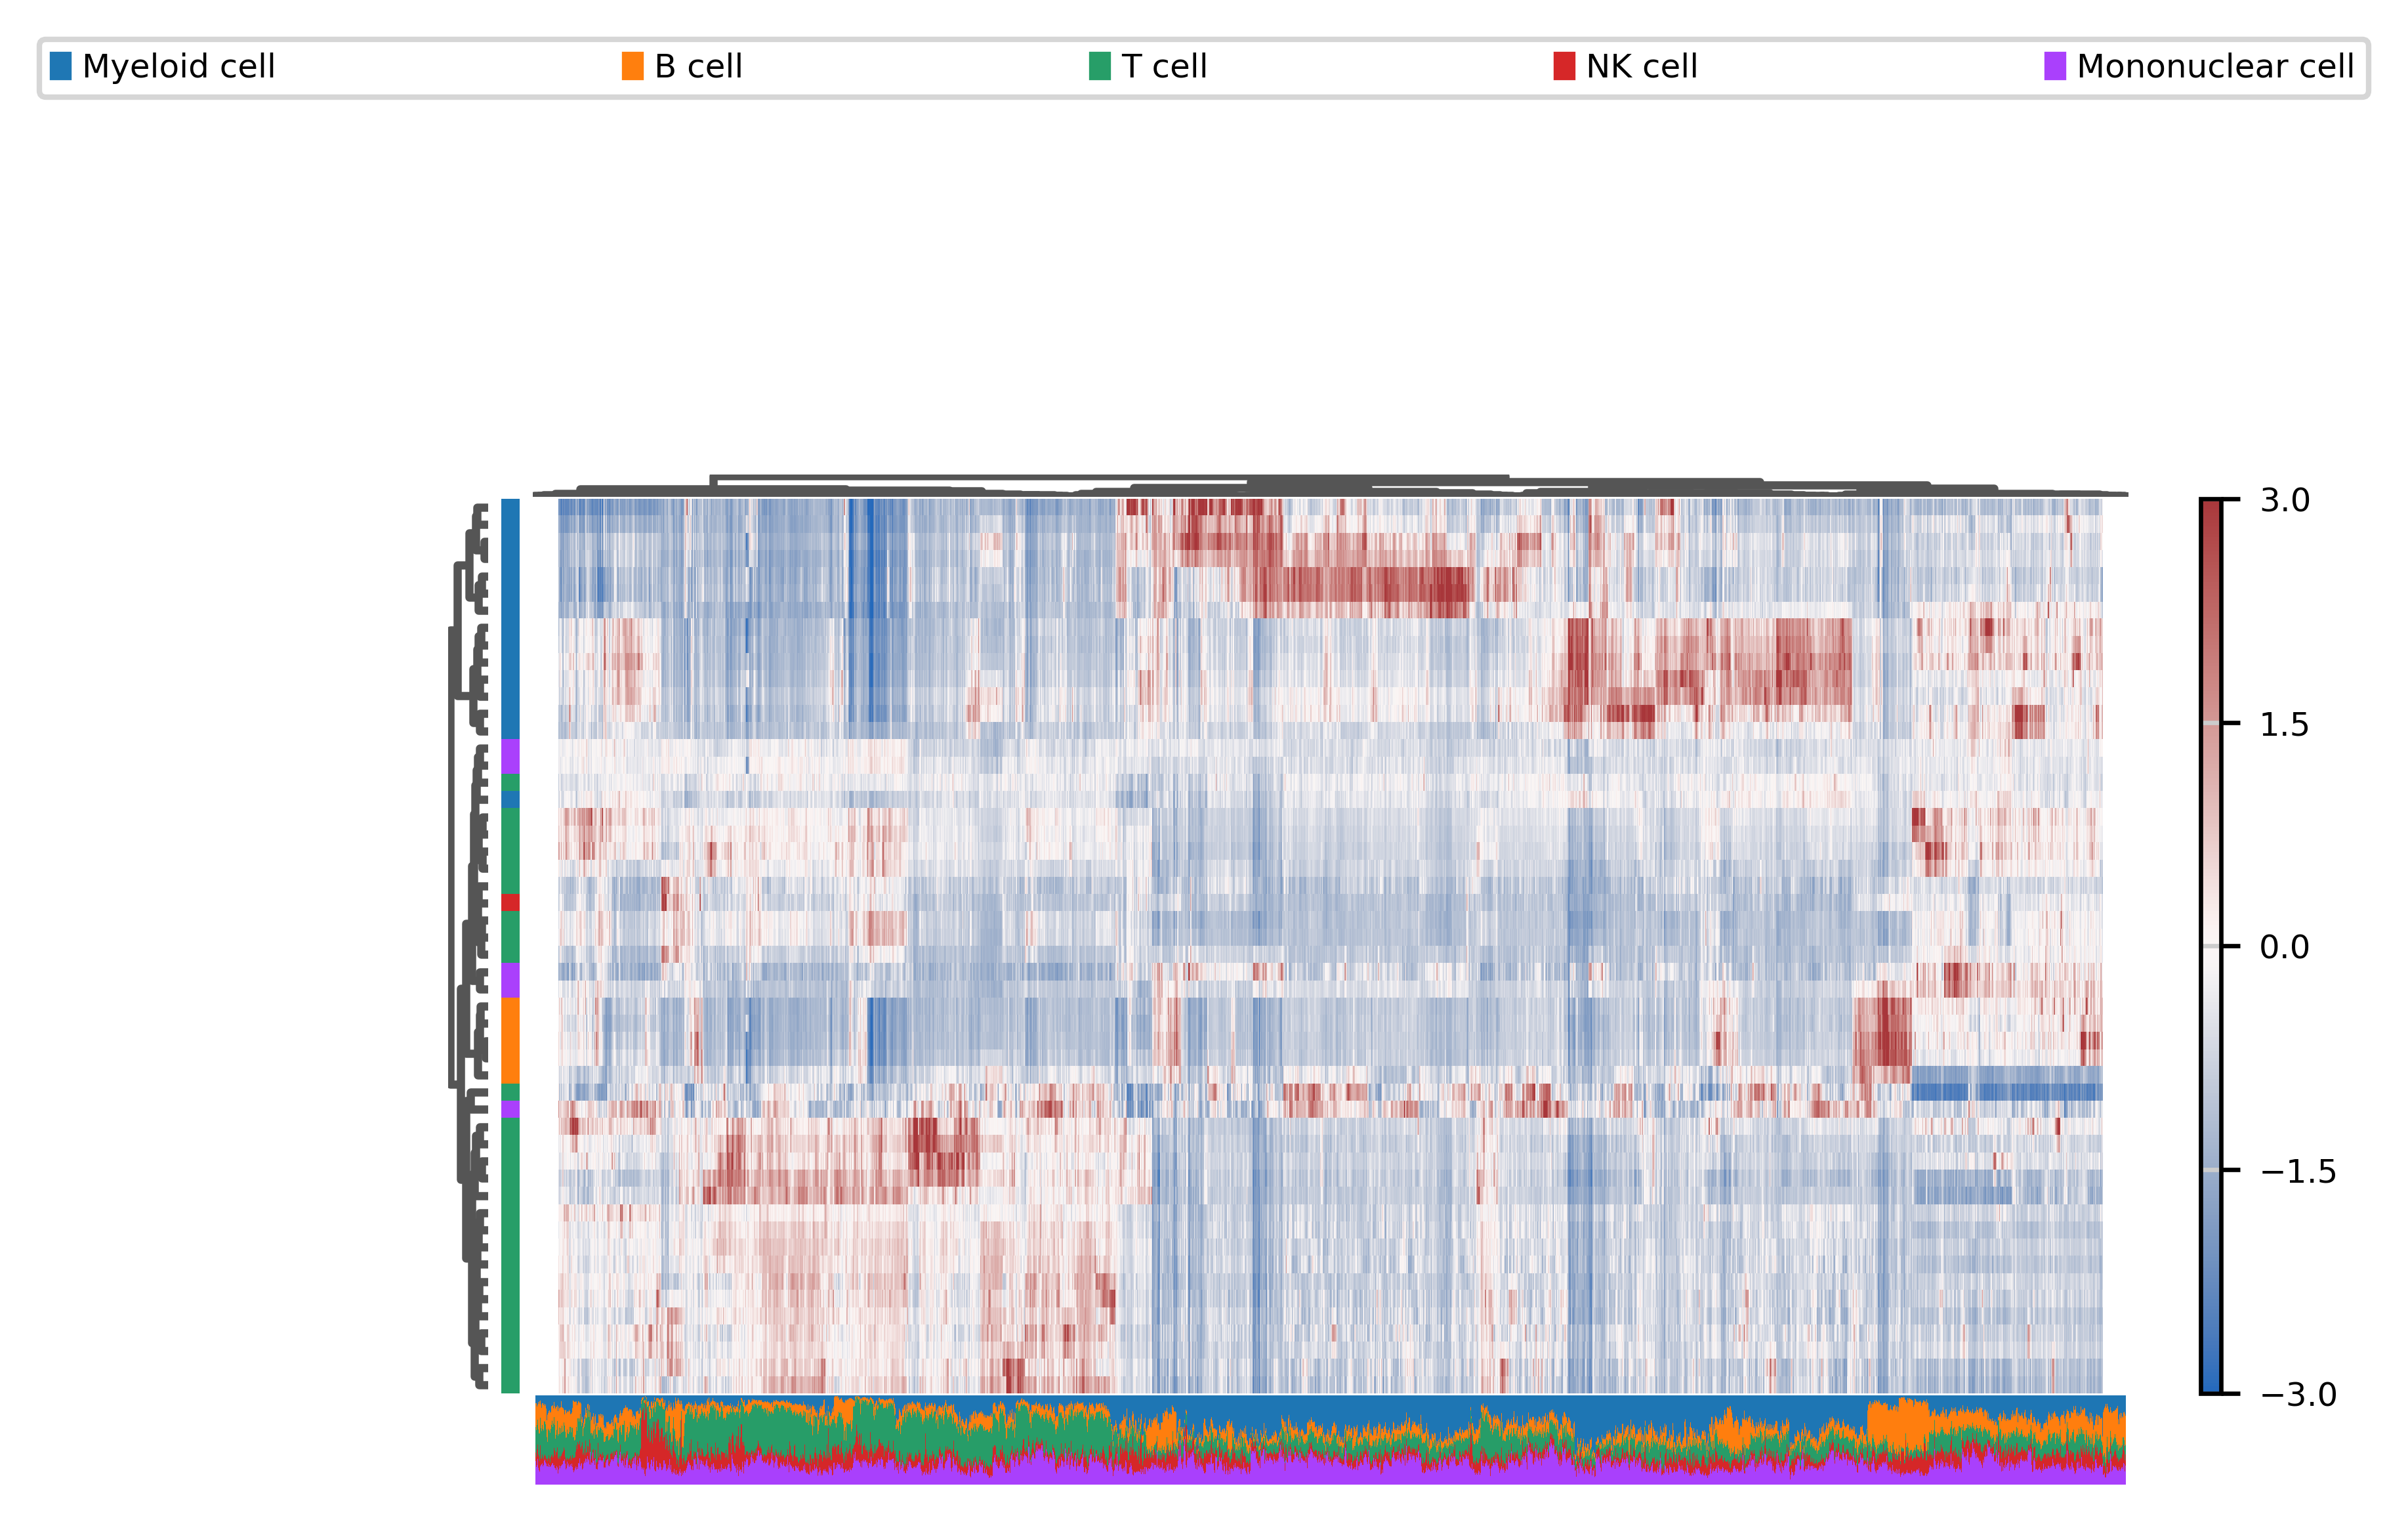

In [14]:
print((peaks & hv).sum())
fig, ax = muffin.plots.mega_heatmap(dataset[:, peaks & hv], layer="residuals", label_col="Cell type", vmin=-3, vmax=3)

Let's find the differentially bound regions between T-cells and B-cells:

In [15]:
# First subset our dataset
selected = dataset[(dataset.obs["Cell type"] == "B cell") | (dataset.obs["Cell type"] == "T cell")]
muffin.tools.differential_expression_A_vs_B(selected, category="Cell type", 
                                        ref_category="T cell")


Comparing B cell to (reference) T cell
Using DESeq2 with normalization factors per row, per gene


R[write to console]: using pre-existing normalization factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 867 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing

R[write to console]: Error in (function (dds, coef, contrast, res, type = c("apeglm", "ashr",  : 
  type='apeglm' requires installing the Bioconductor package 'apeglm'

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In DESeqDataSet(se, design = design, ignoreRank) :
R[write to console]: 
 
R[write to console]:  some variables in design formula are characters, converting to facto

Let's have a first look at the best markers between B and T cells :

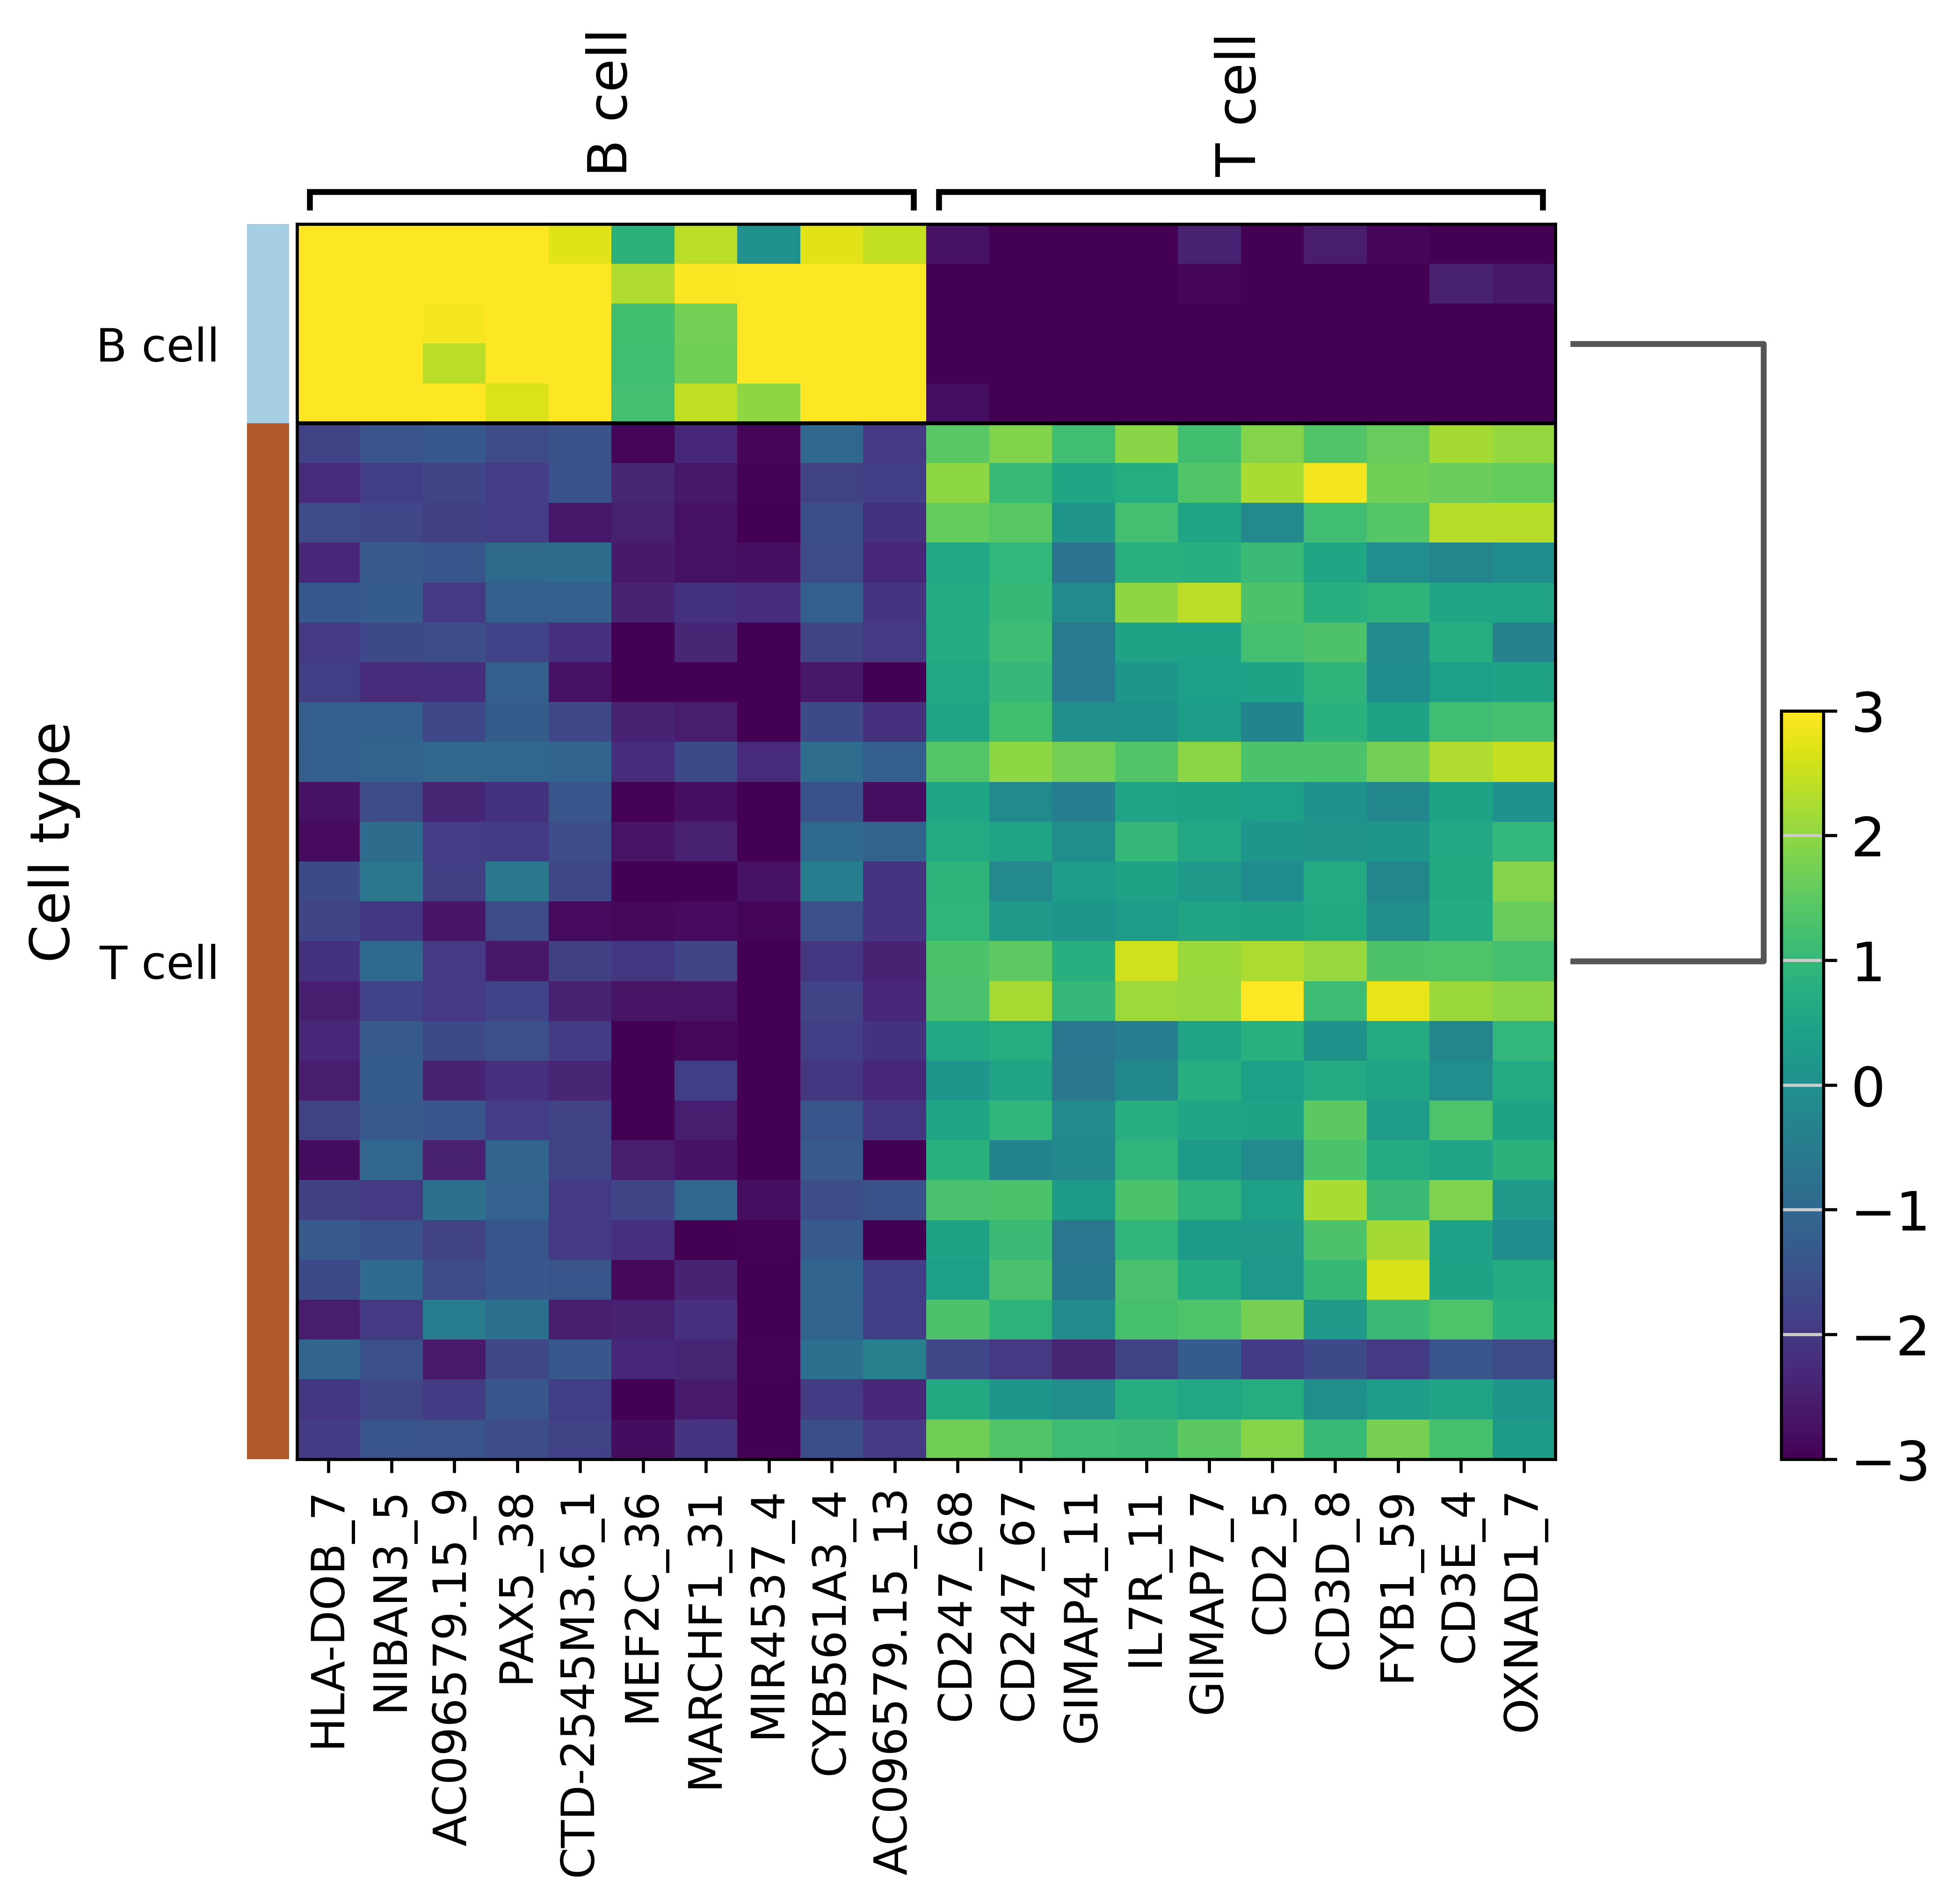

z-score  log2FoldChange        pvalue          padj
CD247_68      -13.920769       -4.526788  4.737805e-44  7.129355e-39
HLA-DOB_7      13.734425        5.195086  6.315563e-43  3.251994e-38
NIBAN3_5       13.732526        4.776342  6.483327e-43  3.251994e-38
AC096579.15_9  13.472273        5.621115  2.277462e-41  8.567698e-37
CD247_67      -13.326811       -5.061501  1.616624e-40  4.865326e-36
...                  ...             ...           ...           ...
CSTA_1         -0.224709       -0.125553  8.222058e-01  1.000000e+00
CASR_10        -1.651376       -1.148689  9.866185e-02  1.000000e+00
RN7SL371P_1    -1.365401       -1.243747  1.721269e-01  1.000000e+00
HSPBAP1_7      -1.062125       -0.866136  2.881791e-01  1.000000e+00
DDX11L1_1      -0.683787       -0.722536  4.941094e-01  1.000000e+00

[163624 rows x 4 columns]

In [16]:
sc.pl.rank_genes_groups_heatmap(selected,layer="residuals", 
                                use_raw=False, vmin=-3, vmax=3, 
                                cmap='viridis')
selected.varm["DE_results"].sort_values("padj")


We can already see genes specific to T cells (CD3E, CD3D...) and some specific to B cells (BLNK, BLK...). We can go further and perform a Genomic Regions Enrichment Analysis to get a GSEA of nearby genes.

In [17]:
# Retrieve DE regions
DE_indexes = (selected.varm["DE_results"]["padj"] < 0.05) & (np.abs(selected.varm["DE_results"]["log2FoldChange"]) > 1.0)
print(DE_indexes.sum(), len(DE_indexes))
all_regions = selected.var[["Chromosome", "Start", "End"]]
query = all_regions[DE_indexes]
# Perform GREA
gsea_results = gsea_obj.find_enriched(query, all_regions, cores=16)
gsea_results

50282 163624


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffinEnv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffinEnv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-b

P(Beta > 0)      Beta  BH corrected p-value  -log10(qval)   
0                                                                        
GO:0002250  3.007645e-48  0.518183          2.852751e-44  4.354474e+01  \
GO:0046649  1.666342e-17  0.258706          7.902629e-14  1.310223e+01   
GO:0042110  3.221943e-15  0.283006          1.018671e-11  1.099197e+01   
GO:0045321  1.717468e-14  0.215619          4.072546e-11  1.039013e+01   
GO:0050851  5.111987e-14  0.431046          9.697439e-11  1.001334e+01   
...                  ...       ...                   ...           ...   
GO:0032886  9.999906e-01 -0.307873          9.999992e-01  3.652373e-07   
GO:0043436  9.999906e-01 -0.154600          9.999992e-01  3.652373e-07   
GO:0007098  9.999943e-01 -0.453311          9.999992e-01  3.652373e-07   
GO:0000226  9.999952e-01 -0.194055          9.999992e-01  3.652373e-07   
GO:0007017  9.999992e-01 -0.173993          9.999992e-01  3.652373e-07   

            -log10(pval)        FC   
0                                    
GO:0002250  4.752177e+01  1.678973  \
GO:0046649  1.677824e+01  1.295253   
GO:0042110  1.449188e+01  1.327113   
GO:0045321  1.376511e+01  1.240630   
GO:0050851  1.329141e+01  1.538866   
...                  ...       ...   
GO:0032886  4.083480e-06  0.735008   
GO:0043436  4.061371e-06  0.856758   
GO:0007098  2.458845e-06  0.635520   
GO:0000226  2.099175e-06  0.823612   
GO:0007017  3.652373e-07  0.840303   

                                                   Name  Total hits  
0                                                                    
GO:0002250                     adaptive immune response        3042  
GO:0046649                        lymphocyte activation        4248  
GO:0042110                            T cell activation        3263  
GO:0045321                         leukocyte activation        4699  
GO:0050851  antigen receptor-mediated signaling pathway        1394  
...                                                 ...         ...  
GO:0032886      regulation of microtubule-based process         335  
GO:0043436                    oxoacid metabolic process        1595  
GO:0007098                             centrosome cycle         150  
GO:0000226        microtubule cytoskeleton organization         993  
GO:0007017                    microtubule-based process        1477  

[9485 rows x 8 columns]

We do observe an enrichment of immune and T/B Cells related terms.

In [50]:
import plotly.offline as pyo
pyo.init_notebook_mode()
gsea_obj.cluster_treemap(gsea_results)

P(Beta > 0)      Beta  BH corrected p-value  -log10(qval)   
0                                                                        
GO:0050863  3.211991e-13  0.310831          4.352247e-10      9.361286  \
GO:0051249  5.029353e-13  0.267080          5.300379e-10      9.275693   
GO:0042113  3.299498e-12  0.337146          2.086383e-09      8.680606   
GO:0002694  1.546220e-11  0.232911          8.147722e-09      8.088964   
GO:0046631  5.170521e-11  0.394302          2.335352e-08      7.631648   
...                  ...       ...                   ...           ...   
GO:0032729  2.681676e-05  0.375759          2.422951e-03      2.615655   
GO:0032753  1.901057e-04  0.529063          1.335692e-02      1.874294   
GO:0001816  5.004537e-04  0.112232          2.985411e-02      1.524996   
GO:0032623  5.829100e-04  0.335426          3.330664e-02      1.477469   
GO:0032663  5.829100e-04  0.335426          3.330664e-02      1.477469   

            -log10(pval)        FC   
0                                    
GO:0050863     12.493226  1.364558  \
GO:0051249     12.298488  1.306145   
GO:0042113     11.481552  1.400944   
GO:0002694     10.810729  1.262269   
GO:0046631     10.286466  1.483349   
...                  ...       ...   
GO:0032729      4.571594  1.456097   
GO:0032753      3.721005  1.697341   
GO:0001816      3.300636  1.118773   
GO:0032623      3.234398  1.398537   
GO:0032663      3.234398  1.398537   

                                                         Name  Total hits   
0                                                                           
GO:0050863                 Regulation of t<br>cell activation        2289  \
GO:0051249          Regulation of<br>lymphocyte<br>activation        2799   
GO:0042113                               B cell<br>activation        1721   
GO:0002694           Regulation of<br>leukocyte<br>activation        3072   
GO:0046631                    Alpha-beta t<br>cell activation        1178   
...                                                       ...         ...   
GO:0032729  Positive<br>regulation of<br>type ii<br>interf...         426   
GO:0032753  Positive<br>regulation of<br>interleukin-4<br>...         257   
GO:0001816                             Cytokine<br>production        2607   
GO:0032623                        Interleukin-2<br>production         379   
GO:0032663       Regulation of<br>interleukin-2<br>production         379   

            Cluster                       Representative  
0                                                         
GO:0050863        0                                       
GO:0051249        0   Regulation of t<br>cell activation  
GO:0042113        0   Regulation of t<br>cell activation  
GO:0002694        0   Regulation of t<br>cell activation  
GO:0046631        0   Regulation of t<br>cell activation  
...             ...                                  ...  
GO:0032729        8  Type ii<br>interferon<br>production  
GO:0032753        8  Type ii<br>interferon<br>production  
GO:0001816        8  Type ii<br>interferon<br>production  
GO:0032623        8  Type ii<br>interferon<br>production  
GO:0032663        8  Type ii<br>interferon<br>production  

[81 rows x 10 columns]

We can save our work to avoid recomputing everything. It can easily be re-loaded using :  anndata.read_h5ad(path)

In [19]:
dataset.write("h3k4me3_results/dataset.h5ad")